## Run the Scattering Transform on the Gap Bridged SWOT Data

In [1]:
import sys
sys.path.append('/home/jskinner1/scattering_transform') # Put ST directory in home
import scattering
import os
import re
import ST
import numpy as np
import glob
import pickle
import re
import matplotlib.pyplot as plt
import torch
import torch.fft
from scipy.ndimage import zoom
from scipy.io import loadmat
import scipy
import JWS_SWOT_toolbox as swot
import cmocean
import pandas as pd
%matplotlib inline

use torch backend


In [2]:
# Function to split our interpolate data into square grids
def load_subgrids(data_dir, pass_number, grid_size=64):
    
    pass_str = f'P{pass_number:03d}'
    cycles = []
    indices = []

    # Load class objects
    with open(os.path.join(data_dir, f'karin_class_{pass_str}.pkl'), 'rb') as f:
        karin = pickle.load(f)
    with open(os.path.join(data_dir, f'nadir_class_{pass_str}.pkl'), 'rb') as f:
        nadir = pickle.load(f)

    # List all SSH and gvort files
    file_list_gvort = sorted(glob.glob(f'{data_dir}/{pass_str}_C*_gvort.npy'))

    all_subgrids = []

    for fname in file_list_gvort:
        m = re.search(rf'{pass_str}_C(\d{{3}})_(\d{{3}})_gvort\.npy$', fname)
        
        cycle = m.group(1)
        cycles.append(cycle)

        index = m.group(2)
        indices.append(index)
        
        if not m:
            print(f'File not loaded: {fname}')
            continue
        # Load and flip longitude dimension
        SSHA = np.load(fname)
        subgrids = split_into_subgrids(SSHA[np.newaxis, :, ::-1], grid_size=grid_size)
        subgrids_arr = np.concatenate(subgrids, axis=0)  # (n_panels, grid_size, grid_size)
        all_subgrids.append(subgrids_arr)

    ssh_subgrids = np.stack(all_subgrids, axis=0)  # (time, n_panels, grid_size, grid_size)
    
    print("ssh_subgrids shape:", ssh_subgrids.shape)
    
    karin.read_cycles = [int(c) for c in cycles] # save the input cycles to the karin class
    karin.read_indices = [int(c) for c in indices]

    # Process the time into something usable 
    time_data = karin.time[:, 0] # take the first time value at each cycle
    valid_mask = time_data < 1e20 # filter bad values out
    valid_times = time_data[valid_mask]

    # Convert to datetime
    reference = pd.Timestamp('2000-01-01', tz='UTC')
    datetime_array = reference + pd.to_timedelta(valid_times, unit='s')
    print("Date range:", datetime_array.min(), "to", datetime_array.max())

    karin.datetime = datetime_array
    
    return karin, nadir, ssh_subgrids

def split_into_subgrids(field, grid_size=64):
    # field shape: (1, H, W)
    H, W = field.shape[1], field.shape[2]
    subgrids = []
    for i in range(0, H, grid_size):
        for j in range(0, W, grid_size):
            if i + grid_size <= H and j + grid_size <= W:
                subgrids.append(field[:, i:i+grid_size, j:j+grid_size])
    return subgrids

def plot_subgrid_panels(ssh_subgrids, frame, cmap=cmocean.cm.balance):
    subgrid_arr = ssh_subgrids[frame]  # shape: (n_panels, nx, ny)
    n_panels = subgrid_arr.shape[0]

    n_cols = int(np.ceil(np.sqrt(n_panels)))
    n_rows = int(np.ceil(n_panels / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axes = axes.ravel()

    for k in range(n_panels):
        ax = axes[k]
        im = ax.imshow(subgrid_arr[k].T, origin='lower', cmap=cmap)
        ax.set_title(f"Panel {k}")
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Turn off unused axes
    for k in range(n_panels, len(axes)):
        axes[k].axis('off')

    plt.suptitle(f"Grids for frame {frame}", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_scattering_simple(data, output_number, sim_name, j1_min=1, j1_max=4, j2_max=4, vmin = -0.2, vmax = 0.2):

    index = 0 # index for the snapshot to plot 
    J = 6

    s22 = data['s22'][:, :, :]
    s21 = data['s21'][:, :, :]
    image_input = data['input_field'][index, :, :]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi = 150)
    
    # Subplot 0: Original image
    axs[0].imshow(image_input[:, :].T, origin='lower', interpolation='bicubic', vmin = vmin, vmax = vmax, cmap=cmocean.cm.balance)
    #axs[0].imshow(image_input[:, :], origin='lower', interpolation='bicubic')
    axs[0].tick_params(axis='both', which='major', labelsize=13)

    # Sparsity
    s21_mn = s21.nanmean(dim=(0)).squeeze().cpu()
    s21_std = s21.std(dim=(0)).squeeze().cpu()

    j1_mean = []
    j1_se = []

    for i in range(j1_min, j1_max+1):
        j1 = i
        j2_range = np.arange(i, j2_max+1)
        s21 = s21_mn[i-1, i-1:j2_max] # takes into account python 0 indexing 
        s21_sd = s21_std[i-1, i-1:j2_max]
        axs[1].errorbar(j2_range, s21 , yerr=s21_sd, fmt='o-', capsize=5, label=f'$j_1 = {j1}$')

    axs[1].set_xlabel(r'$j_2$', fontsize=20)
    axs[1].set_ylabel(r'${\rm s}_{21}$', fontsize=20)
    axs[1].set_xticks(np.arange(1, s21_mn.shape[0] + 1))
    axs[1].grid(True, axis='y', linestyle='-', linewidth=0.5)
    axs[1].set_ylim([0, 0.25])
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    
    # Shape
    s22_mn = s22.nanmean(dim=(0)).squeeze().cpu()
    s22_std = s22.std(dim=(0)).squeeze().cpu()

    j1_mean = []
    j1_se = [] 
    j2_mean = []
    j2_se = [] 

    for i in range(j1_min, j1_max+1):
        j1 = i
        j2_range = np.arange(i, j2_max+1)
        s22 = s22_mn[i-1, i-1:j2_max] # takes into account python 0 indexing 
        s22_sd = s22_std[i-1, i-1:j2_max]
        axs[2].errorbar(j2_range, s22, yerr=s22_sd, fmt='s-', capsize=5, label=f'$j_1 = {i}$')
    axs[2].axhline(1.0, color='k', linestyle='--', linewidth=1.0)
    axs[2].set_xlabel(r'$j_2$', fontsize=20)
    axs[2].set_ylabel(r'${\rm s}_{22}$', fontsize=20)
    axs[2].set_xticks(np.arange(1, s22_mn.shape[0] +1))
    axs[2].grid(True, axis='y', linestyle='-', linewidth=0.5)
    axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
    axs[2].set_ylim([0.5, 2.5])
    axs[2].tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    # os.makedirs(f'./plots_{sim_name}/', exist_ok=True)
    plt.savefig(f'./ST_{sim_name}.pdf')
    plt.show()
    return fig, axs

def plot_multi_region_scattering_timeseries(
    ssh_subgrids_list, karin_list, region_labels,
    swot,
    J=6, L=4,
    j_values_to_save=[(2, 3), (4, 5)],
    ylims_s21=(0.05, 0.20),
    ylims_s22=(0.5, 1.8),
    error_type='std'  # 'std' for standard deviation, 'se' for standard error
):

    assert error_type in ['std', 'se'], "error_type must be either 'std' or 'se'"

    swot.set_plot_style()
    colors = plt.cm.tab20.colors
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    for r, (ssh_subgrids, karin, label) in enumerate(zip(
        ssh_subgrids_list, karin_list, region_labels
    )):
        n_times, n_panels = ssh_subgrids.shape[0], ssh_subgrids.shape[1]
        cycles = karin.read_cycles  # List of cycle numbers

        saved_s21 = {pair: [] for pair in j_values_to_save}
        saved_s21_std = {pair: [] for pair in j_values_to_save}
        saved_s22 = {pair: [] for pair in j_values_to_save}
        saved_s22_std = {pair: [] for pair in j_values_to_save}

        for t in range(n_times):
            scat = swot.scattering_func(ssh_subgrids[t], J=J, L=L)
            s21 = scat['s21'].cpu().numpy()
            s22 = scat['s22'].cpu().numpy()

            for pair in j_values_to_save:
                j1, j2 = pair
                if j1 <= s21.shape[1] and j2 <= s21.shape[2]:
                    vals21 = s21[:, j1 - 1, j2 - 1]
                    saved_s21[pair].append(np.nanmean(vals21))
                    saved_s21_std[pair].append(np.nanstd(vals21))
                if j1 <= s22.shape[1] and j2 <= s22.shape[2]:
                    vals22 = s22[:, j1 - 1, j2 - 1]
                    saved_s22[pair].append(np.nanmean(vals22))
                    saved_s22_std[pair].append(np.nanstd(vals22))

        for i, pair in enumerate(j_values_to_save):
            color = colors[(i + r * len(j_values_to_save)) % len(colors)]

            # Convert to arrays
            cyc = np.array(cycles, dtype=float)
            s21_vals = np.array(saved_s21[pair])
            s22_vals = np.array(saved_s22[pair])
            err21 = np.array(saved_s21_std[pair])
            err22 = np.array(saved_s22_std[pair])

            if error_type == 'se':
                err21 /= np.sqrt(n_panels)
                err22 /= np.sqrt(n_panels)

            # Insert NaNs where cycles are not consecutive
            cyc_diff = np.diff(cyc)
            gap_indices = np.where(cyc_diff > 1)[0]

            for gap in reversed(gap_indices):
                cyc = np.insert(cyc, gap + 1, np.nan)
                s21_vals = np.insert(s21_vals, gap + 1, np.nan)
                err21 = np.insert(err21, gap + 1, np.nan)
                s22_vals = np.insert(s22_vals, gap + 1, np.nan)
                err22 = np.insert(err22, gap + 1, np.nan)

            # Plot with broken lines
            axes[0].errorbar(
                cyc, s21_vals, yerr=err21,
                label=f'{label} $S_{{21}}{pair}$', color=color,
                marker='o', markersize=3, linewidth=1.0, capsize=2
            )
            axes[1].errorbar(
                cyc, s22_vals, yerr=err22,
                label=f'{label} $S_{{22}}{pair}$', color=color,
                marker='o', markersize=3, linewidth=1.0, capsize=2
            )

    # Finalize plots
    axes[0].set_ylabel('$s_{21}$', fontsize=15)
    axes[0].set_title('$s_{21}$ Timeseries', fontsize=15)
    axes[0].legend(title="Scale Pairs", fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left')
    axes[0].set_ylim(ylims_s21)
    axes[0].tick_params(labelsize=13)

    axes[1].set_xlabel('Cycle', fontsize=15)
    axes[1].set_ylabel('$s_{22}$', fontsize=15)
    axes[1].set_title('$s_{22}$ Timeseries', fontsize=15)
    axes[1].legend(title="Scale Pairs", fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left')
    axes[1].set_ylim(ylims_s22)
    axes[1].tick_params(labelsize=13)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

## Analysis Code

In [3]:
# Import all of the processed data
# Kuroshio extension crossover
karin_KE04, nadir_KE04, ssh_subgrids_KE04 = load_subgrids('./outputs/KE_P004/', pass_number=4)
karin_KE19, nadir_KE19, ssh_subgrids_KE19 = load_subgrids('./outputs/KE_P019/', pass_number=19)

# Gulf stream crossover near WNA
karin_GS22, nadir_GS22, ssh_subgrids_GS22 = load_subgrids('./outputs/GS_P022/', pass_number=22)
karin_GS09, nadir_GS09, ssh_subgrids_GS09 = load_subgrids('./outputs/GS_P009/', pass_number=9)

# ACC crossover
karin_SO06, nadir_SO06, ssh_subgrids_SO06 = load_subgrids('./outputs/SO_P006/', pass_number=6)
karin_SO17, nadir_SO17, ssh_subgrids_SO17 = load_subgrids('./outputs/SO_P017/', pass_number=17)

# ENA crossover
karin_ENA05, nadir_ENA05, ssh_subgrids_ENA05 = load_subgrids('./outputs/ENA_P005/', pass_number=5)
karin_ENA18, nadir_ENA18, ssh_subgrids_ENA18 = load_subgrids('./outputs/ENA_P018/', pass_number=18)

ssh_subgrids shape: (68, 5, 64, 64)
Date range: 2023-04-02 00:12:22.559805989+00:00 to 2023-07-09 08:44:51.363096833+00:00
ssh_subgrids shape: (93, 5, 64, 64)
Date range: 2023-03-31 13:37:54.069116831+00:00 to 2023-07-09 21:51:38.679439187+00:00
ssh_subgrids shape: (66, 5, 64, 64)
Date range: 2023-03-31 15:51:58.800361872+00:00 to 2023-07-10 00:05:43.238549352+00:00
ssh_subgrids shape: (93, 5, 64, 64)
Date range: 2023-03-31 05:05:47.604925871+00:00 to 2023-07-09 13:19:32.220871568+00:00
ssh_subgrids shape: (88, 3, 64, 64)
Date range: 2023-03-31 02:42:02.143414617+00:00 to 2023-07-09 10:55:46.712239146+00:00
ssh_subgrids shape: (89, 3, 64, 64)
Date range: 2023-03-31 11:27:26.857136607+00:00 to 2023-07-09 19:41:11.530380011+00:00
ssh_subgrids shape: (88, 3, 64, 64)
Date range: 2023-04-02 01:24:43.217438698+00:00 to 2023-07-09 09:57:12.195652723+00:00
ssh_subgrids shape: (72, 6, 64, 64)
Date range: 2023-03-31 12:26:08.242927909+00:00 to 2023-07-09 20:39:52.680040836+00:00


In [4]:
# Simple line for printing out whats in the data classes 
import pandas as pd
print([attr for attr in dir(karin_GS22) if not attr.startswith('_')])
print(karin_KE04.lat_max) #for example
print(karin_KE04.lat_min) 
print(karin_KE04.datetime)

['bad_cycles', 'bad_strips_quality', 'coordinates', 'datetime', 'distances', 'dx', 'dy', 'good_cycles', 'good_strips_list', 'hvar_cycles', 'lat', 'lat_max', 'lat_min', 'lon', 'middle_width', 'num_cycles', 'pass_number', 'read_cycles', 'read_indices', 'removed_strips_high_variance', 'ssh', 'ssh_mean', 'ssha', 'ssha_mean_highpass', 'swath_width', 't_coord', 'tide', 'time', 'total_width', 'track_length', 'x_coord', 'x_grid', 'x_obs', 'y_coord', 'y_grid']
38
32
DatetimeIndex(['2023-04-02 00:12:22.559805989+00:00',
               '2023-04-03 00:03:00.330475330+00:00',
               '2023-04-03 23:53:38.069752693+00:00',
               '2023-04-04 23:44:15.774349928+00:00',
               '2023-04-05 23:34:53.538477540+00:00',
               '2023-04-06 23:25:31.777444839+00:00',
               '2023-04-07 23:16:09.980795145+00:00',
               '2023-04-08 23:06:48.146363139+00:00',
               '2023-04-09 22:57:26.280843973+00:00',
               '2023-04-10 22:48:04.379302859+00:00'

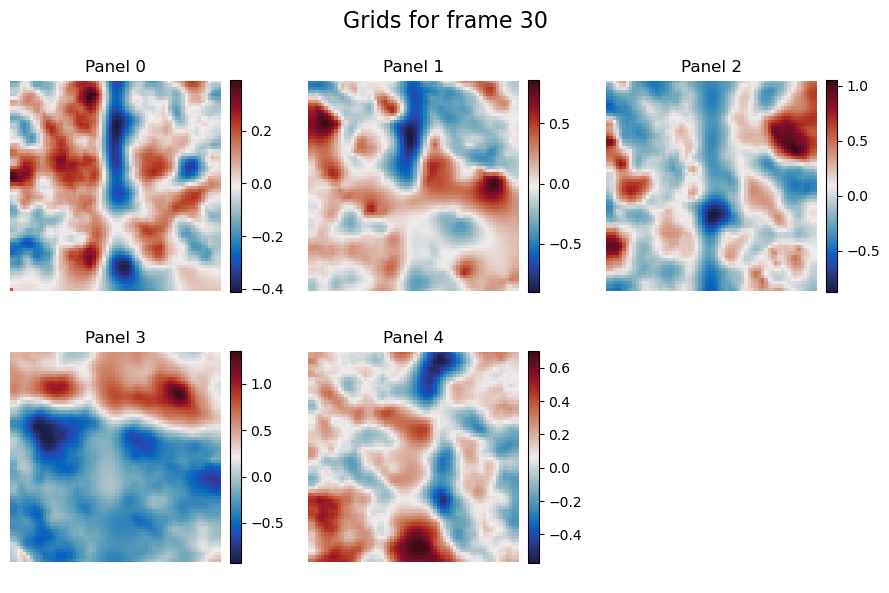

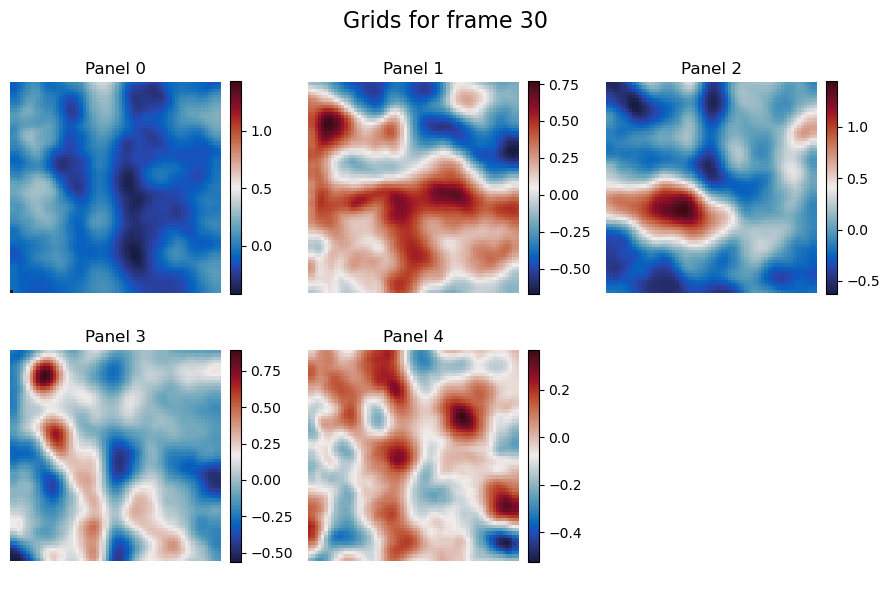

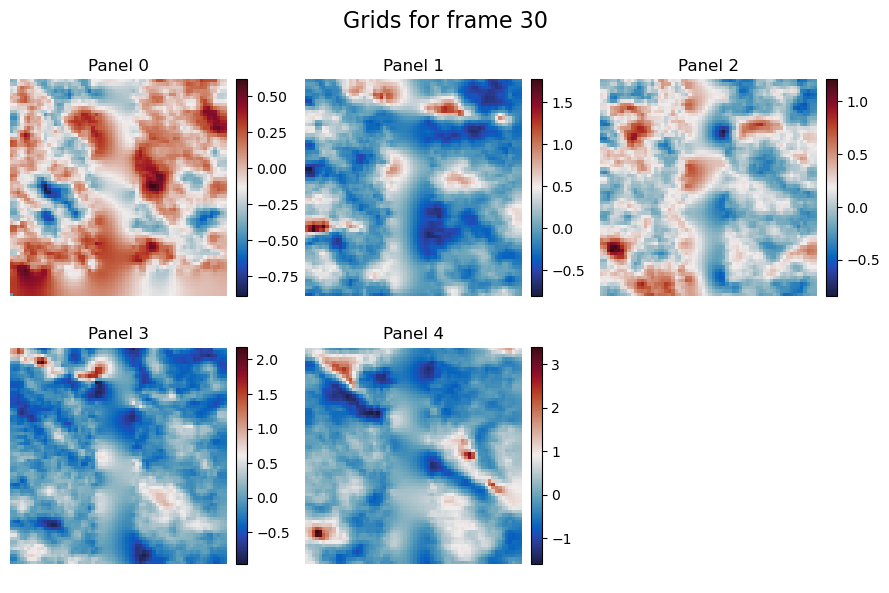

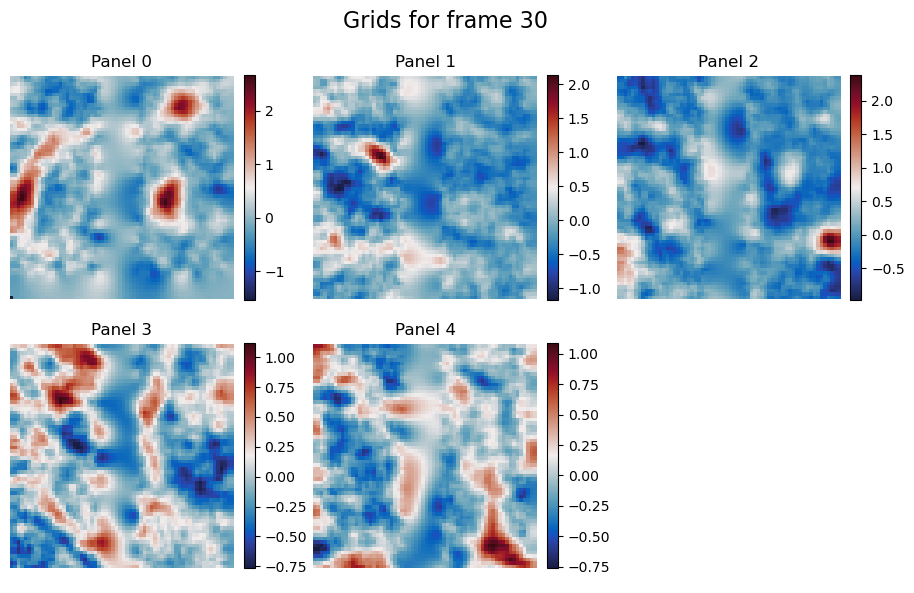

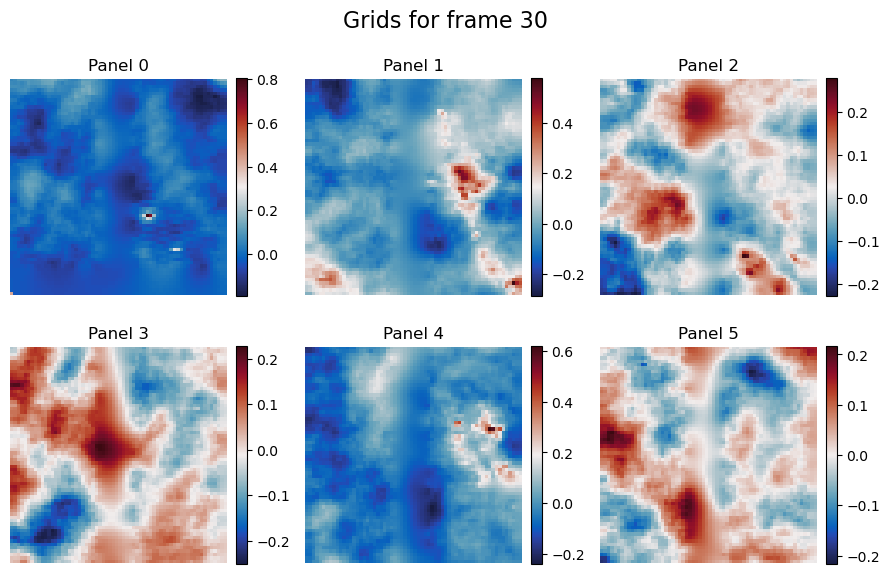

In [5]:
frame = 30 

plot_subgrid_panels(ssh_subgrids_KE04, frame=frame)
plot_subgrid_panels(ssh_subgrids_KE19, frame=frame)
plot_subgrid_panels(ssh_subgrids_GS22, frame=frame)
plot_subgrid_panels(ssh_subgrids_GS09, frame=frame)
plot_subgrid_panels(ssh_subgrids_ENA18, frame=frame)

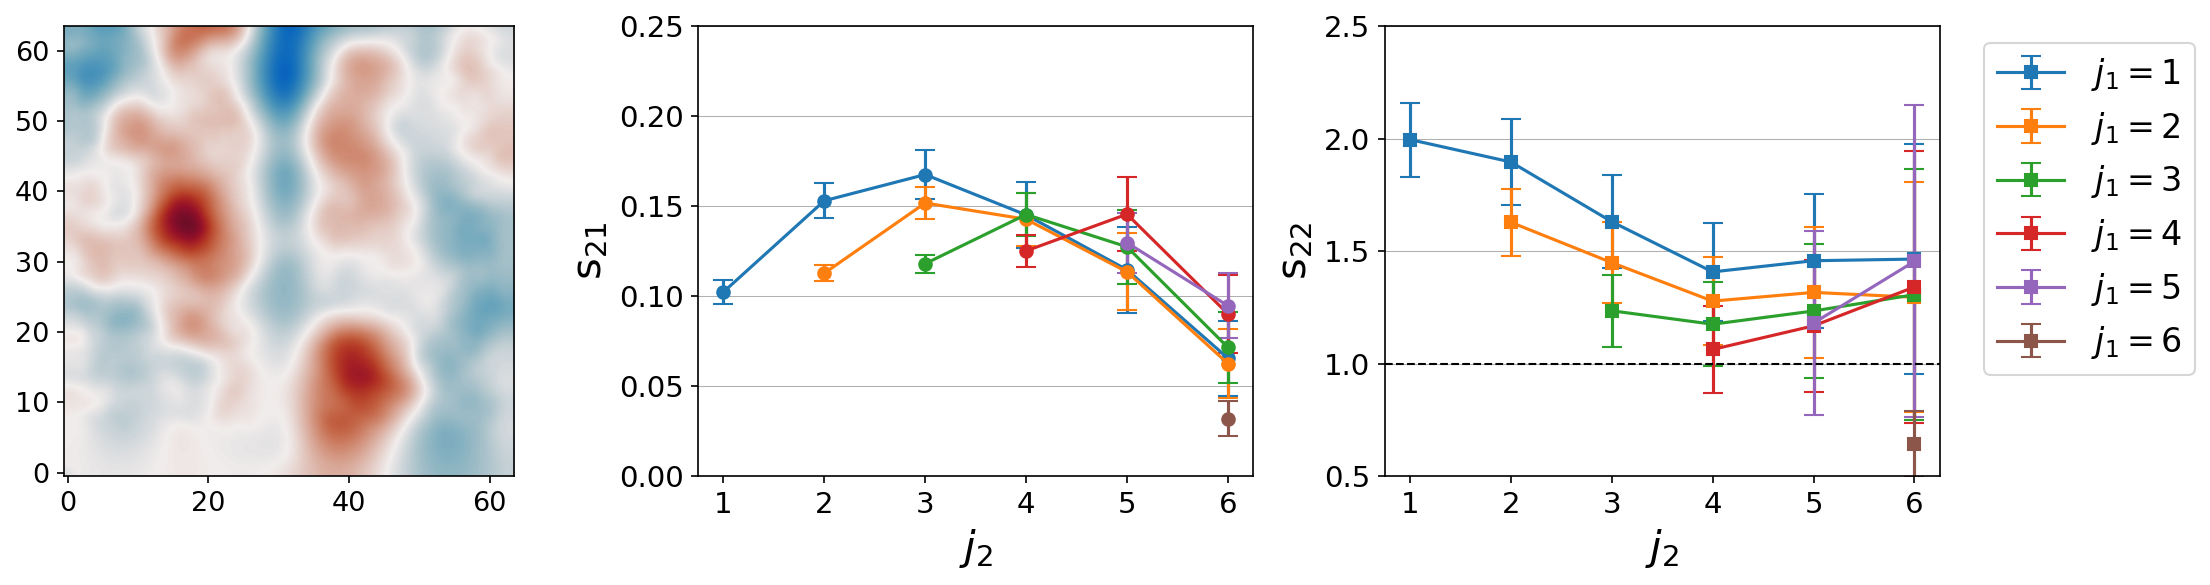

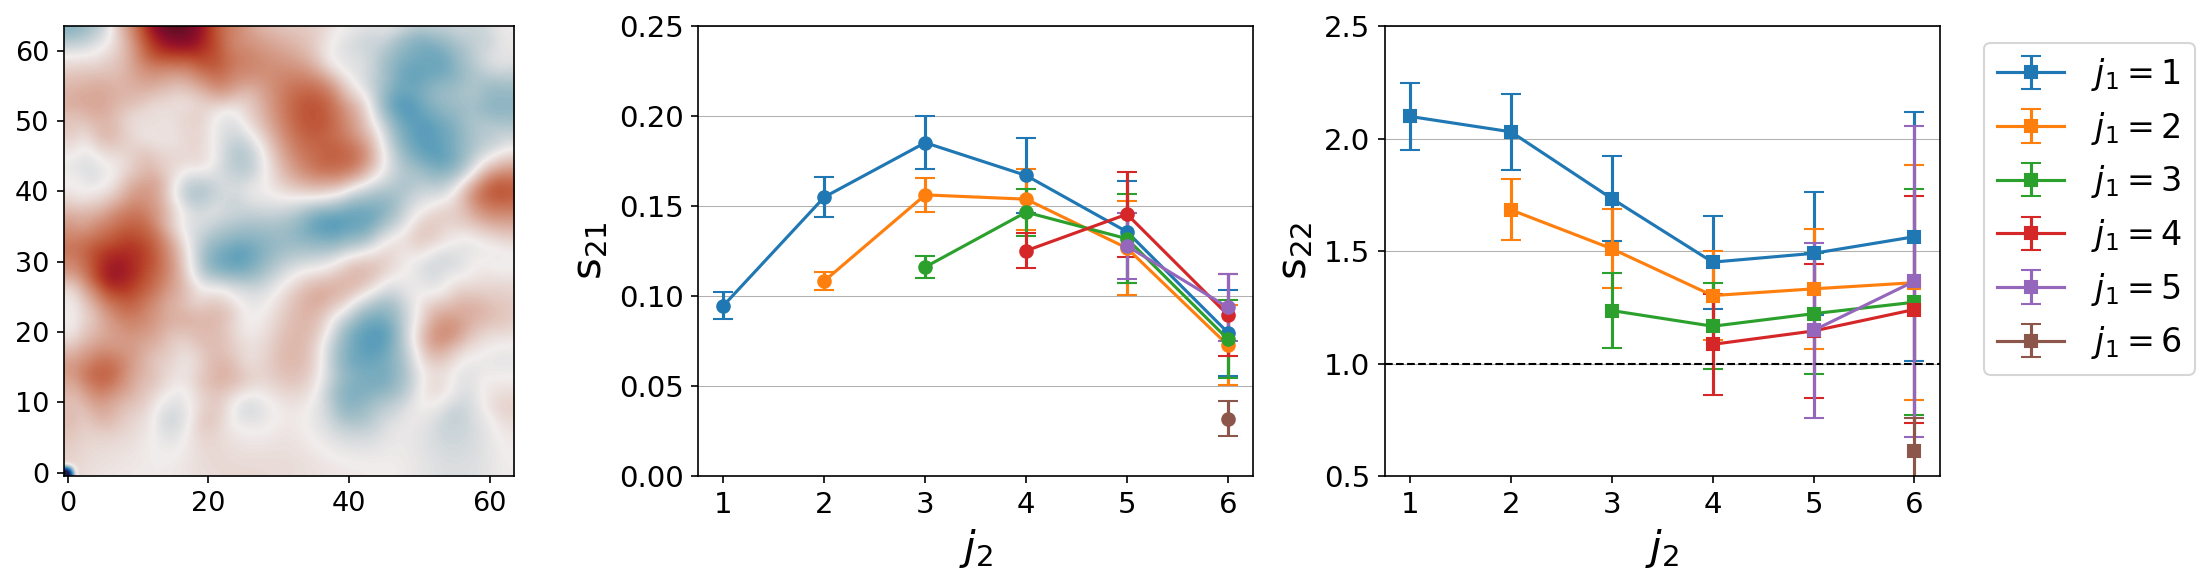

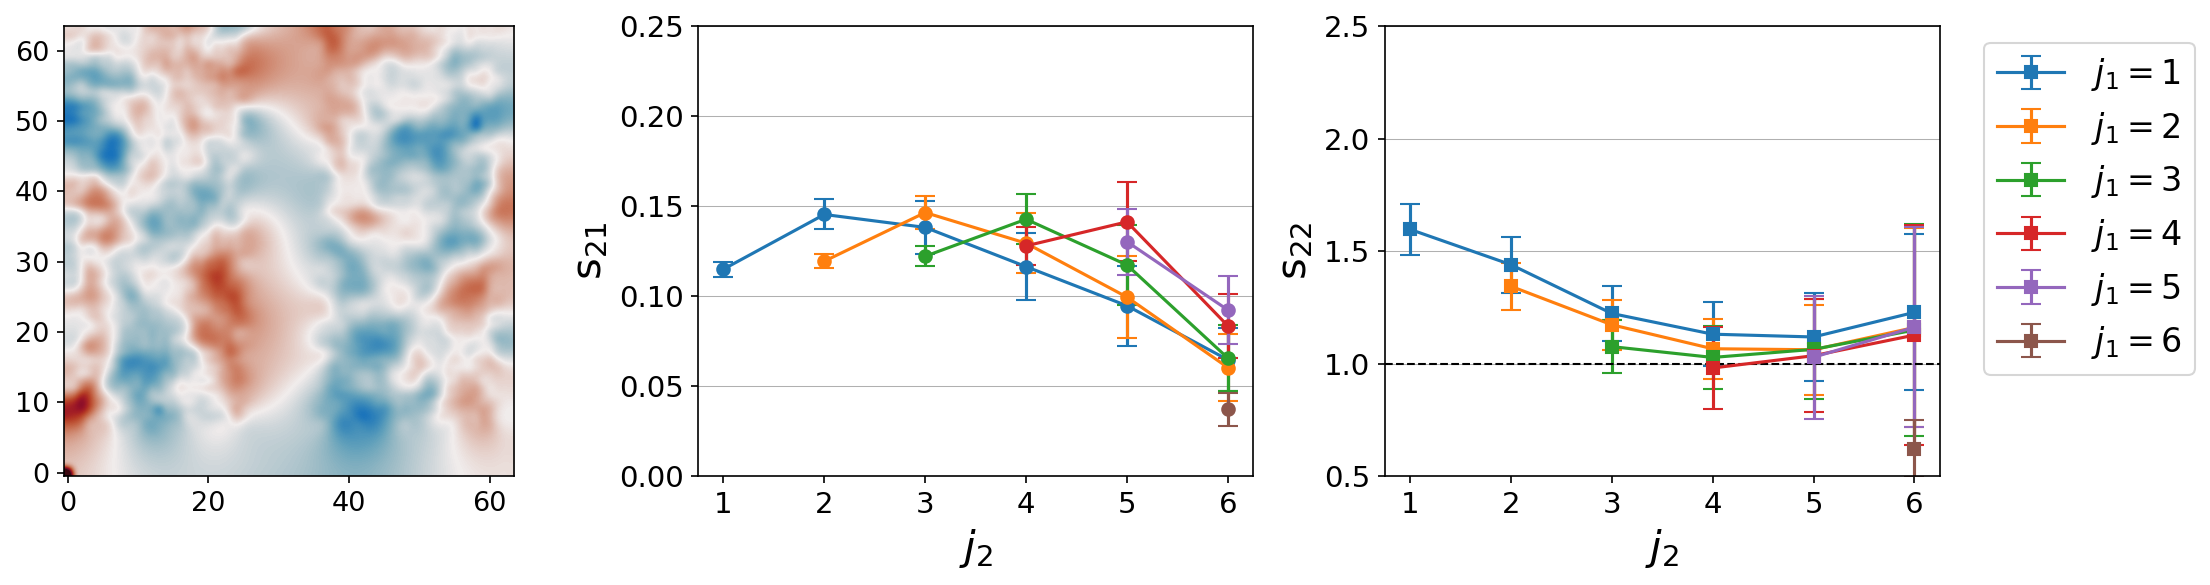

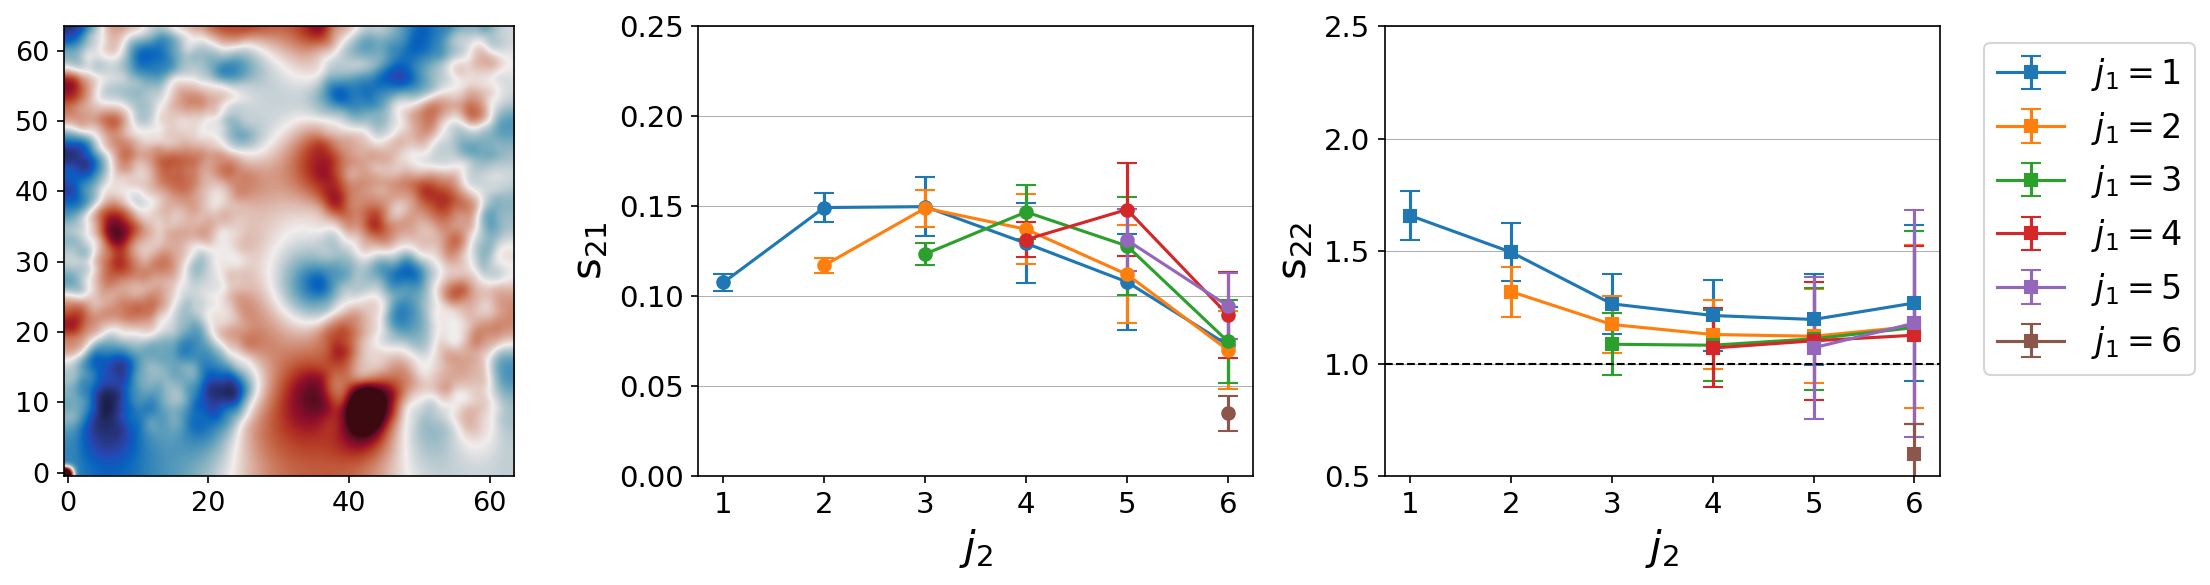

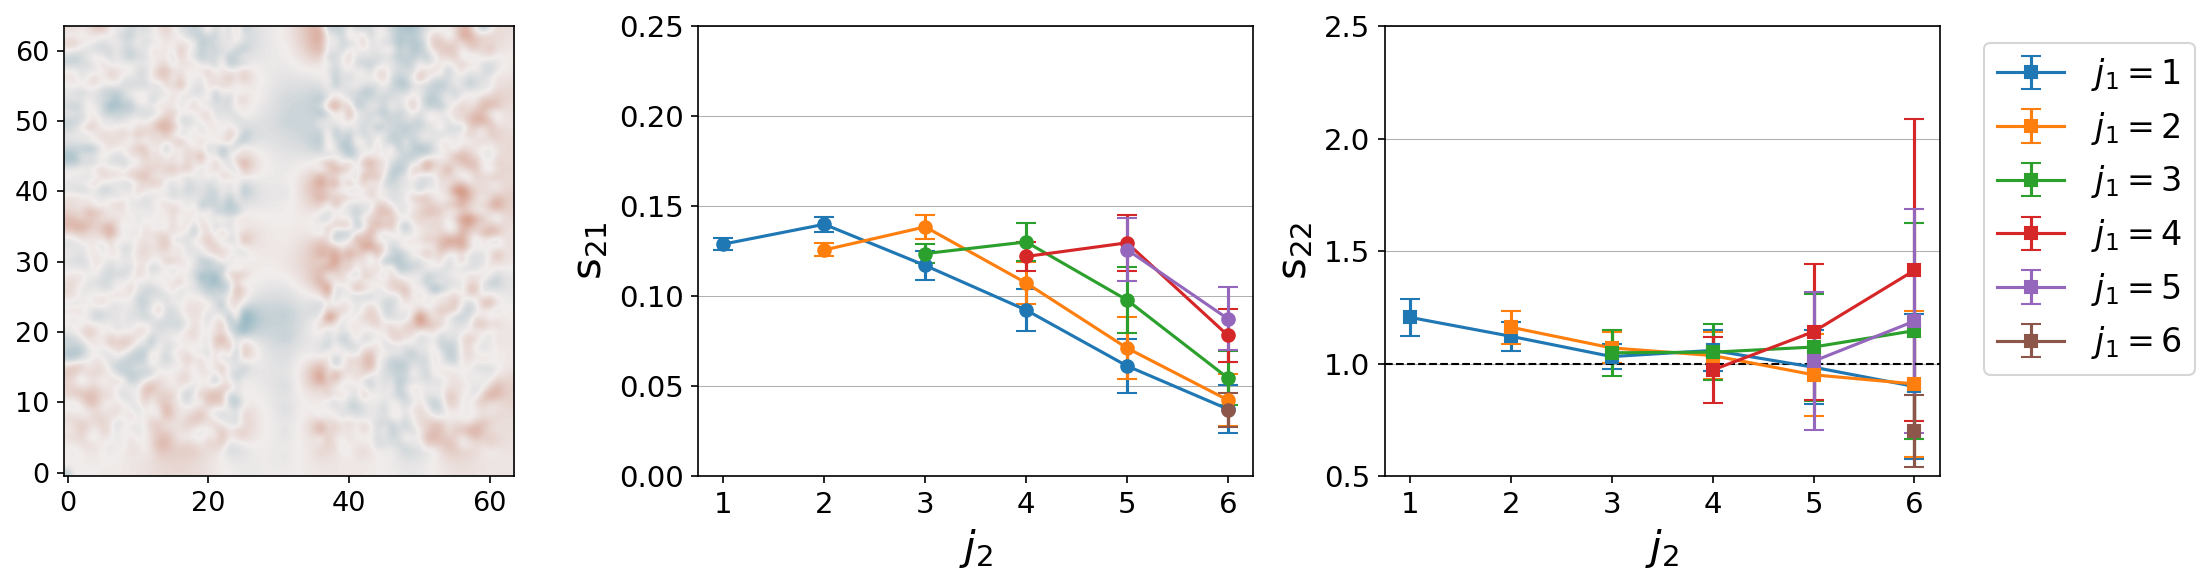

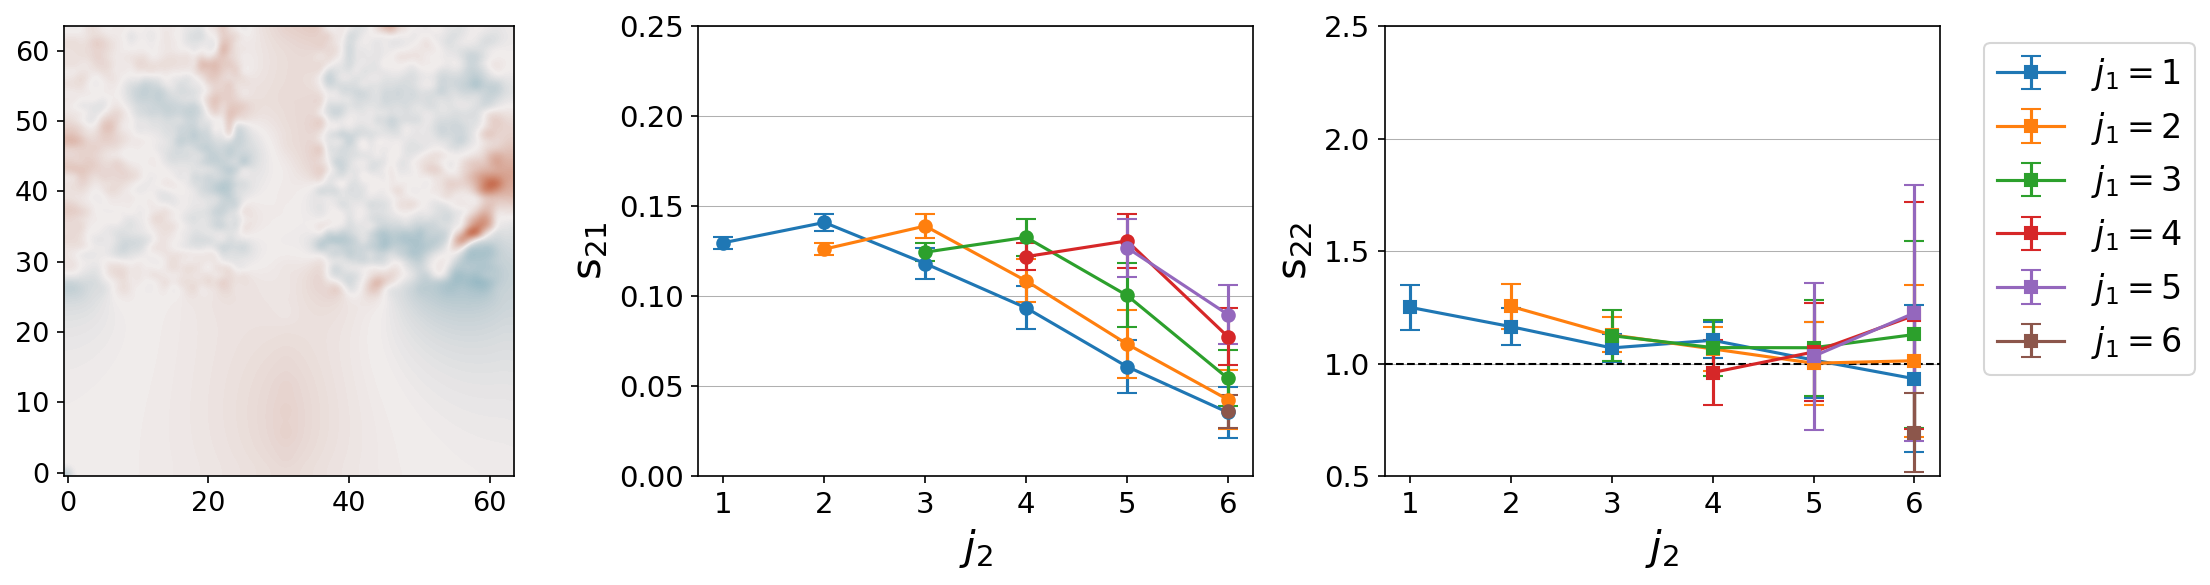

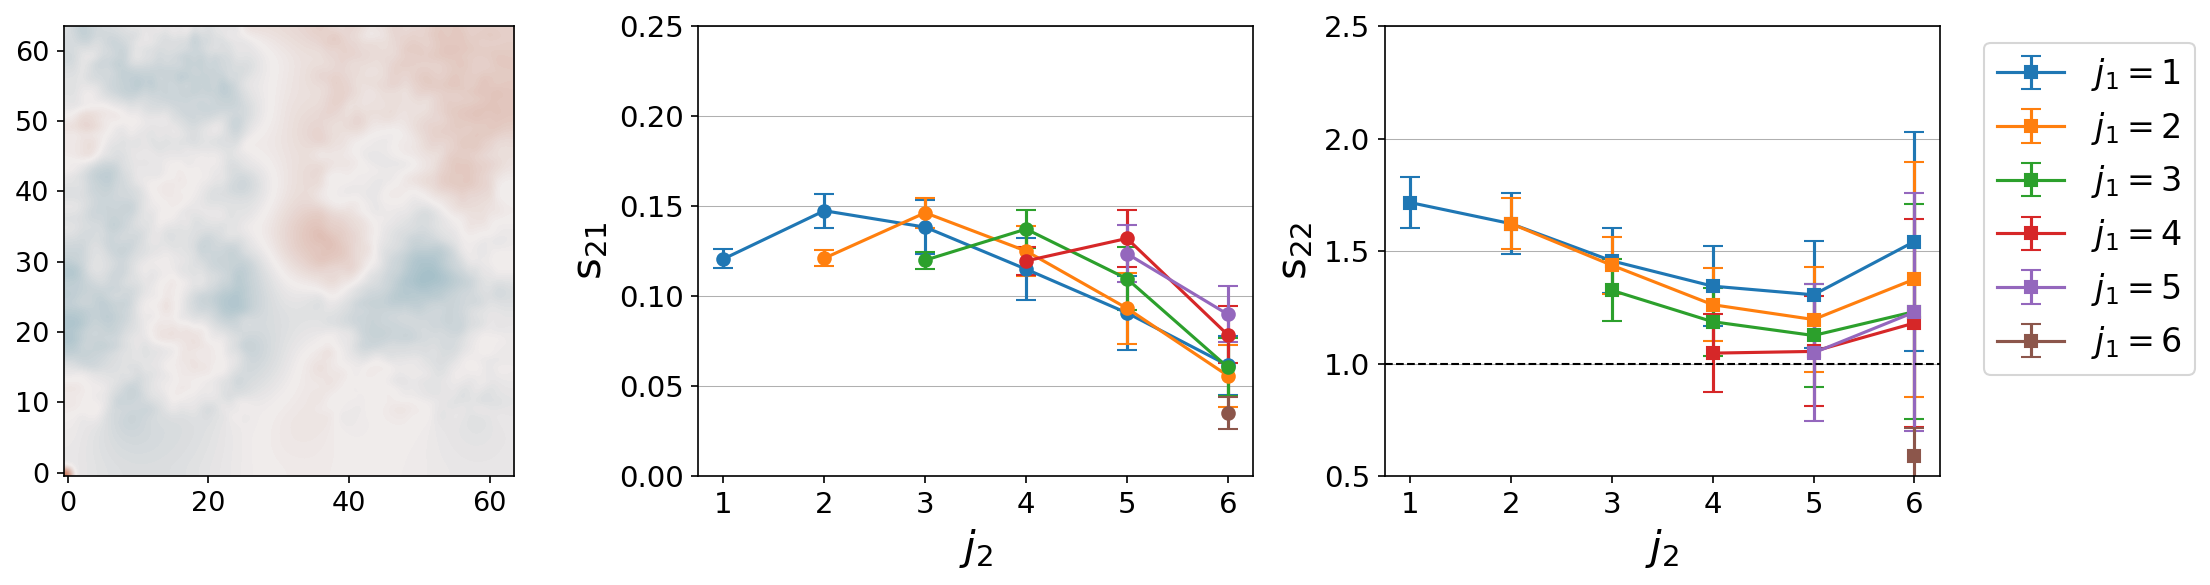

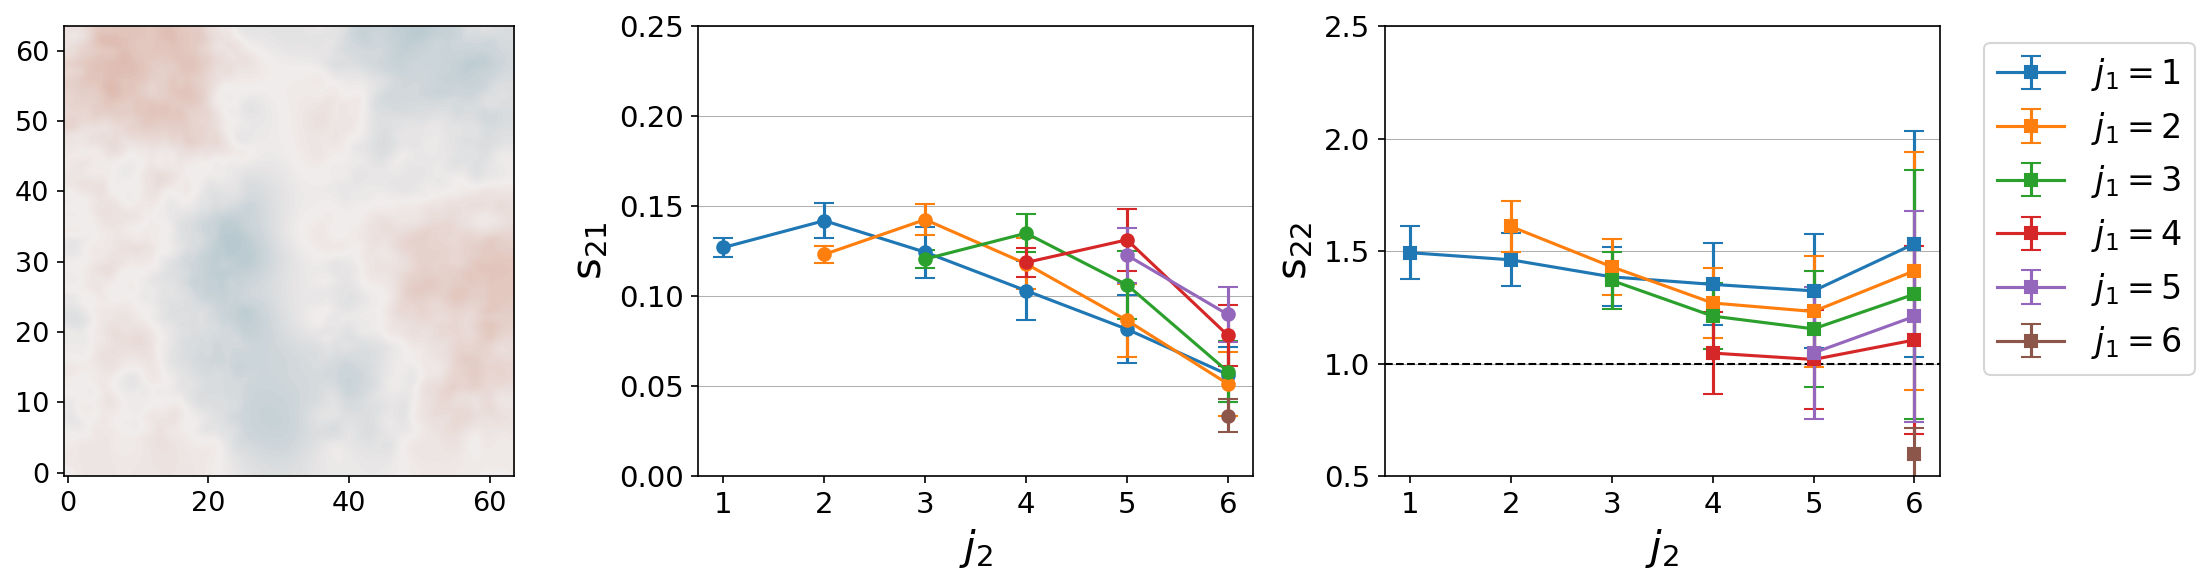

In [6]:
# Parameters
J = 6  # Number of scales for 64x64 input
L = 4
time = 30  # Not used in this snippet — remove or use as needed

# All region subgrids
region_data = {
    'KE04': ssh_subgrids_KE04,
    'KE19': ssh_subgrids_KE19,
    'GS22': ssh_subgrids_GS22,
    'GS09': ssh_subgrids_GS09,
    'SO06': ssh_subgrids_SO06,
    'SO17': ssh_subgrids_SO17,
    'ENA18': ssh_subgrids_ENA18, 
    'ENA05': ssh_subgrids_ENA05
}

# Process and plot
scattering_results = {}
for name, grid in region_data.items():
    reshaped = grid.reshape(-1, *grid.shape[2:])  # Collapse time + panel
    scat = swot.scattering_func(reshaped, J=J, L=L)
    scattering_results[name] = scat
    plot_scattering_simple(scat, 10, name, j1_min=1, j1_max=6, j2_max=6, vmin=-1, vmax=1)


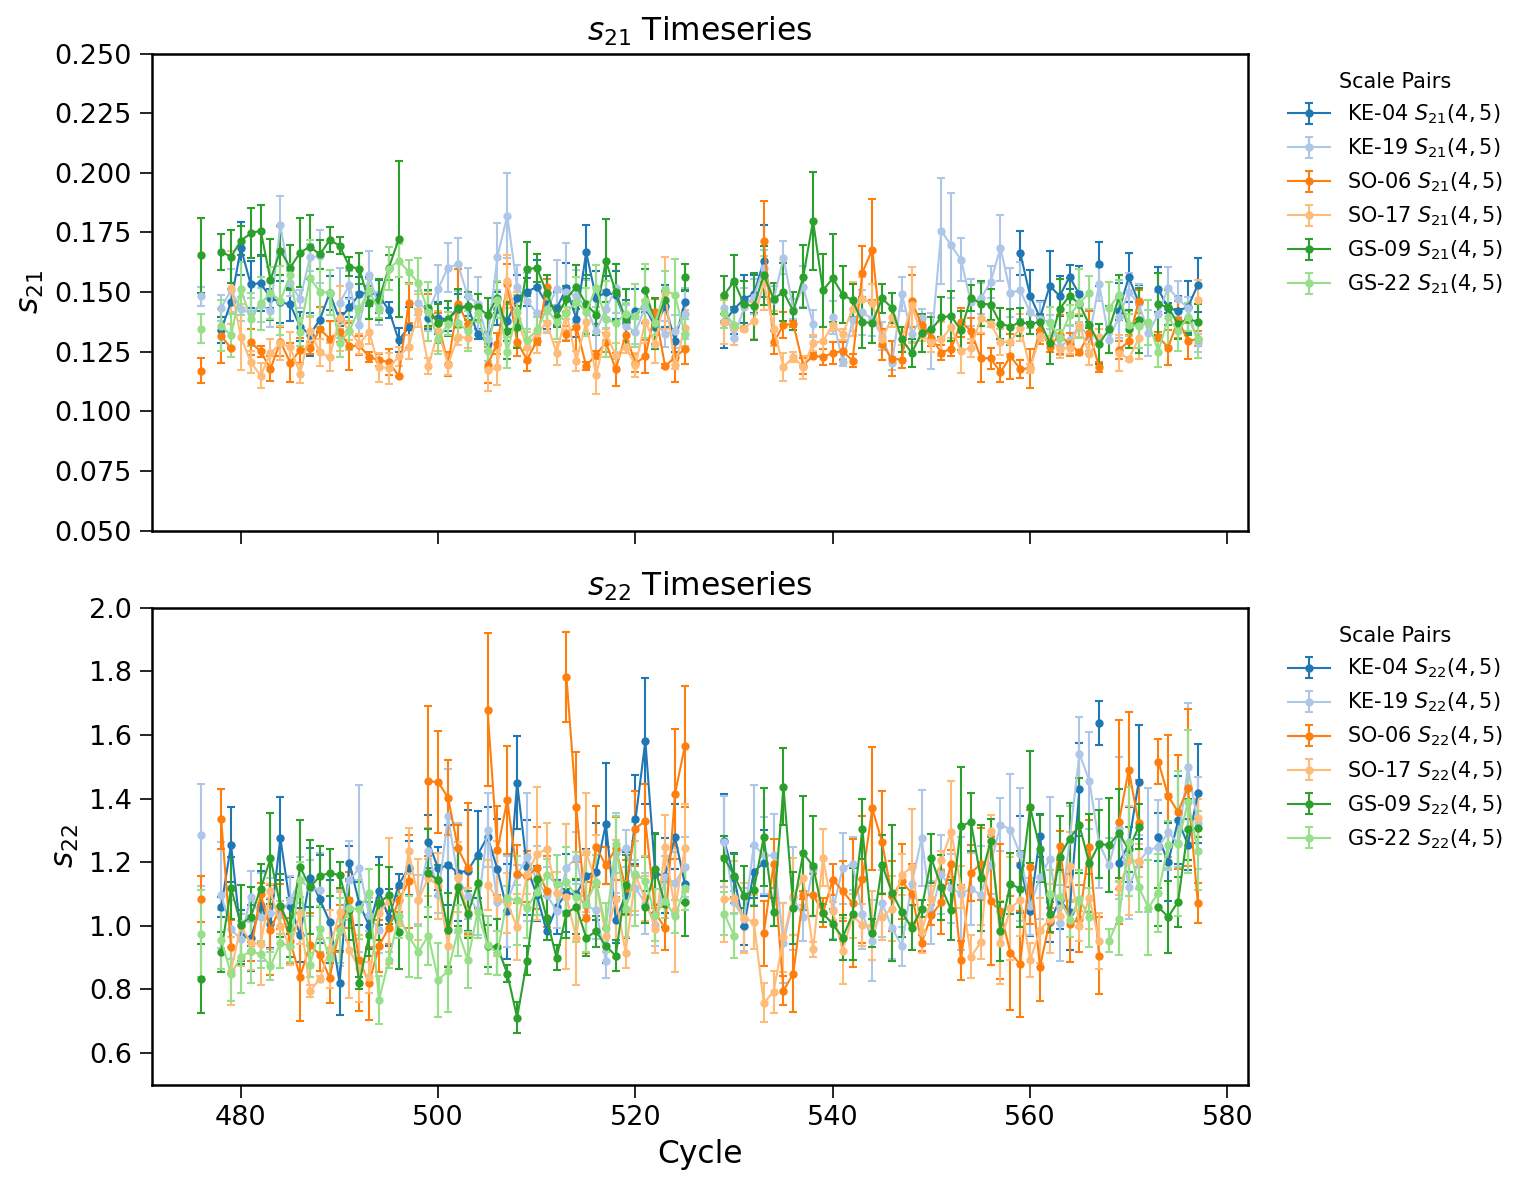

In [7]:
# Plot a comparative timeseries of multiple regions
plot_multi_region_scattering_timeseries(
    ssh_subgrids_list=[ssh_subgrids_KE04, ssh_subgrids_KE19,
                       ssh_subgrids_SO06, ssh_subgrids_SO17,
                       ssh_subgrids_GS09, ssh_subgrids_GS22],
    karin_list=[karin_KE04, karin_KE19, karin_SO06, karin_SO17, karin_GS09, karin_GS22],
    region_labels=["KE-04", "KE-19", "SO-06", "SO-17",  "GS-09", "GS-22"],
    swot=swot,
    j_values_to_save=[(4, 5)],
    ylims_s21=(0.05, 0.25),
    ylims_s22=(0.5, 2.0),
    error_type='se' # can choose standard error (se) or standard deviation (std)
)

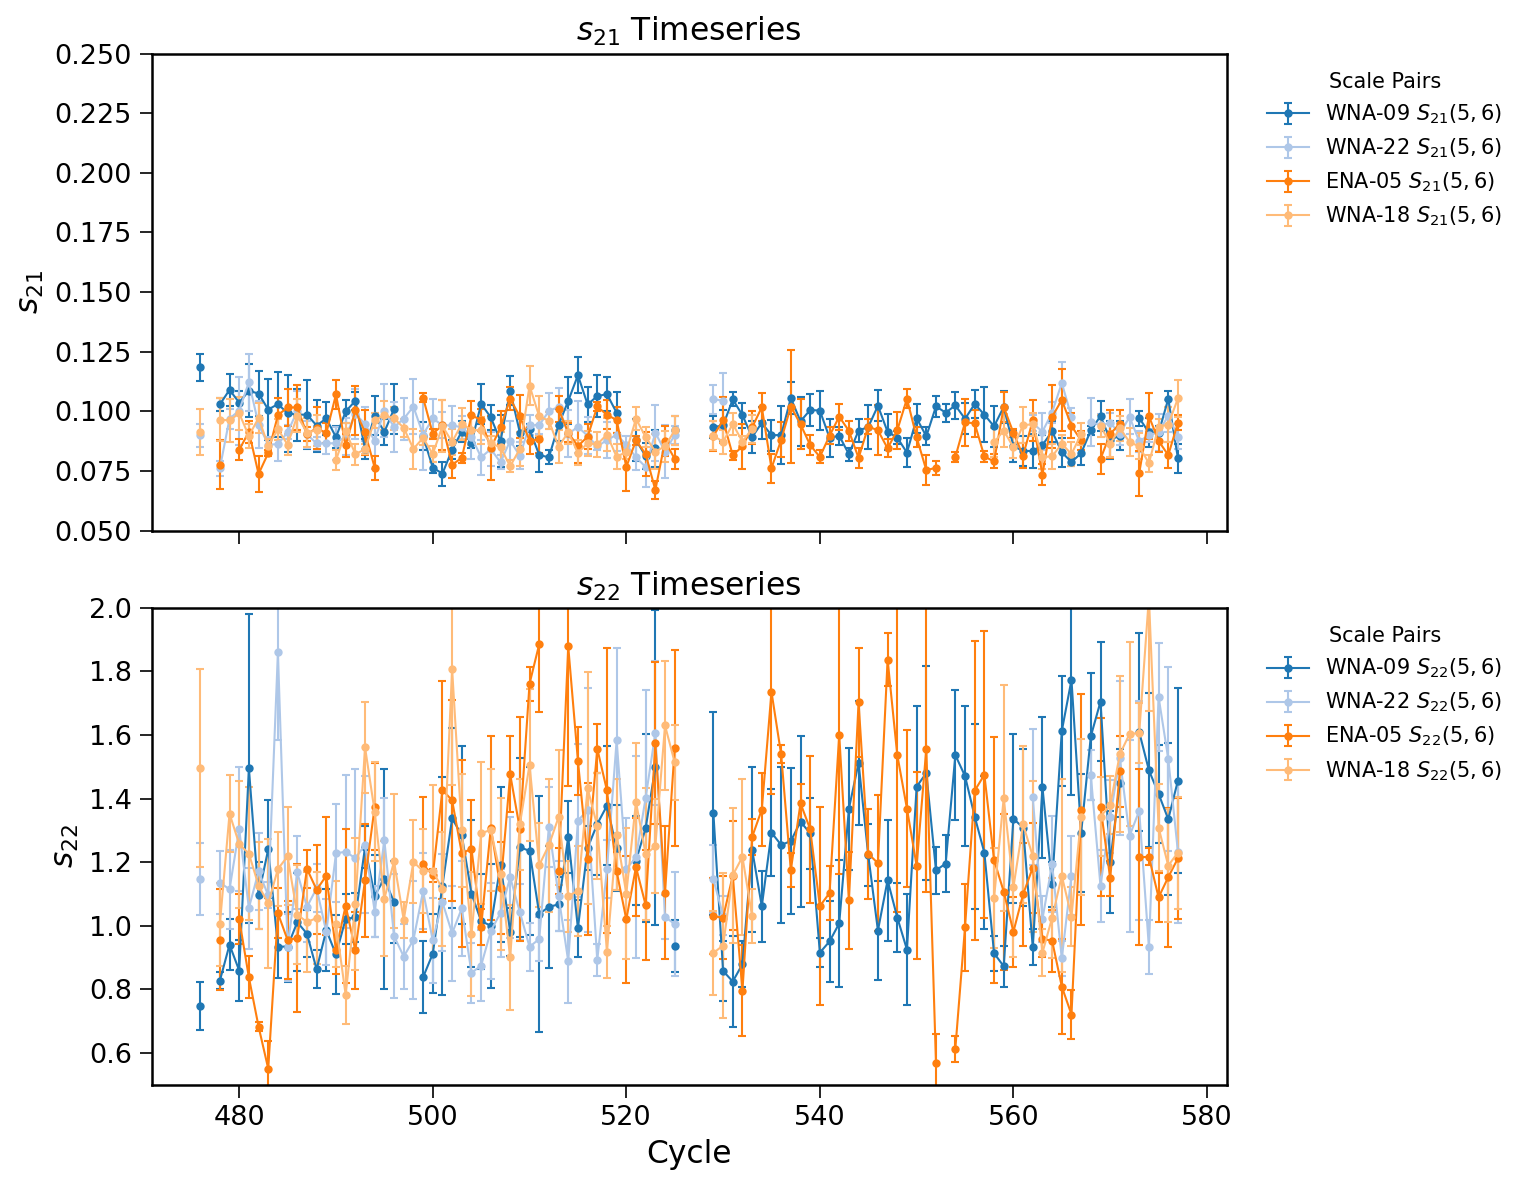

In [10]:
# Plot the timeseries for just the ENA and WNA regions so we can compare it to the NA simulation
plot_multi_region_scattering_timeseries(
    ssh_subgrids_list=[ssh_subgrids_GS09, ssh_subgrids_GS22, ssh_subgrids_ENA05, ssh_subgrids_ENA18],
    karin_list=[karin_GS09, karin_GS22, karin_ENA05, karin_ENA18],
    region_labels=["WNA-09", "WNA-22", "ENA-05", "WNA-18" ],
    swot=swot,
    j_values_to_save=[(5, 6)],
    ylims_s21=(0.05, 0.25),
    ylims_s22=(0.5, 2.0),
    error_type='se' # can choose standard error (se) or standard deviation (std)
)

In [67]:
print(karin_KE04.read_cycles)

['478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '499', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '525', '529', '530', '531', '532', '533', '559', '560', '561', '562', '563', '564', '565', '567', '569', '570', '571', '573', '574', '575', '576', '577']


In [ ]:
import numpy as np
from itertools import combinations

pass_num = 19

swot.set_plot_style()

# Values to extract at each frame
j_values_to_save = list(combinations(range(2, 6), 2))

saved_s21 = {pair: [] for pair in j_values_to_save}
saved_s22 = {pair: [] for pair in j_values_to_save}

J = 6
L = 4

n_times = ssh_subgrids.shape[0]
cycles = karin.good_cycles[0:n_times]

for t in range(n_times):
    ST_grids = ssh_subgrids[t, :, :, :]
    scat = swot.scattering_func(ST_grids, J=J, L=L)
    s21 = scat['s21']  # (n_panels, J, J)
    s22 = scat['s22']  # (n_panels, J, J)

    # If these are torch tensors, convert to numpy
    if hasattr(s21, "cpu"):
        s21 = s21.cpu().numpy()
    if hasattr(s22, "cpu"):
        s22 = s22.cpu().numpy()

    for (j1, j2) in j_values_to_save:
        # Python 0-indexing
        if j1 <= s21.shape[1] and j2 <= s21.shape[2]:
            saved_s21[(j1, j2)].append(np.nanmean(s21[:, j1 - 1, j2 - 1]))
        if j1 <= s22.shape[1] and j2 <= s22.shape[2]:
            saved_s22[(j1, j2)].append(np.nanmean(s22[:, j1 - 1, j2 - 1]))

# Example of plotting one (j1, j2) pair
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
colors = plt.cm.tab20.colors  # Enough distinct colors

# ---- Top subplot: S21 ----
for i, pair in enumerate(j_values_to_save):
    axes[0].plot(
        cycles,
        saved_s21[pair],
        label=f'$S_{{21}}{pair}$',
        color=colors[i % len(colors)],
        marker='o',
        markersize=3,
        linewidth=1.5
    )
axes[0].set_ylabel('$s_{21}$', fontsize=12)
axes[0].set_title('Temporal Evolution of $s_{21}$', fontsize=14)
axes[0].set_title(f'Pass {pass_num}', fontsize=14, loc='right')
axes[0].grid(True, linestyle='-', alpha=0.6)
axes[0].legend(title="Scale Pairs", fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left')

# ---- Bottom subplot: S22 ----
for i, pair in enumerate(j_values_to_save):
    axes[1].plot(
        cycles,
        saved_s22[pair],
        label=f'$S_{{22}}{pair}$',
        color=colors[i % len(colors)],
        linestyle='-',
        marker='o',
        markersize=3,
        linewidth=1.5
    )
axes[1].set_xlabel('Cycle', fontsize=12)
axes[1].set_ylabel('$s_{22}$', fontsize=12)
axes[1].set_title('Temporal Evolution of $s_{22}$', fontsize=14)
axes[1].grid(True, linestyle='-', alpha=0.6)
axes[1].legend(title="Scale Pairs", fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left')

# Layout adjustments
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


NameError: name 'ssh_subgrids' is not defined

### Same as above but loop over all of the cycles

In [ ]:
# Now we will do the same but loop over the cycles 
# Import, cleanup, and plot the data 
cycle_nums = [] 
for filename in os.listdir(data_dir):
    # Use a regular expression to extract the cycle number from the filename
    match = re.search(r'_C(\d{3})_', filename)
    if match:
        cycle_num = match.group(1)  # Extract the cycle number
        cycle_nums.append(cycle_num)

# Remove duplicates and sort the pass numbers
cycle_nums = sorted(set(cycle_nums))
print(cycle_nums)

In [ ]:
# Loop over the cycle numbers and build the combined dataset and make plots of it 
def plot_scattering_simple(data, output_number, cycle_num, sim_name, j1_min=1, j1_max=4, j2_max=4, vmin=-1e-12, vmax=1e-12):
    index = 0  # index for the snapshot to plot
    J = 6

    s22 = data['s22'][:, :, :]
    s21 = data['s21'][:, :, :]
    image_input = data['input_field'][index, :, :]

    # Create a grid with 2 rows and 2 columns, with the top plot spanning both columns
    fig = plt.figure(figsize=(10, 7), dpi=200)
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

    # Subplot 0: Original image (spans both columns)
    ax0 = fig.add_subplot(gs[0, :])
    im = ax0.imshow(image_input[:, :].T, vmin=vmin, vmax=vmax, origin='lower', interpolation='bicubic', cmap=cmocean.cm.deep_r)
    ax0.set_title(r"$\nabla^2$ SSHA", fontsize=14)
    ax0.set_title(r"Cycle: "+cycle_num, fontsize=14, loc='right')
    ax0.set_xlabel(r"$x$ (grid points)", fontsize=12)
    ax0.set_ylabel(r"$y$ (grid points)", fontsize=12)
    ax0.tick_params(axis='both', which='major', labelsize=10)
    # fig.colorbar(im, ax=ax0, shrink=0.8)

    # Sparsity plot
    ax1 = fig.add_subplot(gs[1, 0])
    s21_mn = s21.nanmean(dim=(0)).squeeze().cpu()
    s21_std = s21.std(dim=(0)).squeeze().cpu()

    for i in range(j1_min, j1_max + 1):
        j1 = i
        j2_range = np.arange(i, j2_max + 1)
        s21_vals = s21_mn[i - 1, i - 1:j2_max]
        s21_sd = s21_std[i - 1, i - 1:j2_max]
        ax1.errorbar(j2_range, s21_vals, yerr=s21_sd, fmt='o-', capsize=5, label=f'$j_1 = {j1}$')

    ax1.set_xlabel(r'$j_2$', fontsize=12)
    ax1.set_ylabel(r'${\rm s}_{21}$', fontsize=12)
    ax1.set_xticks(np.arange(1, s21_mn.shape[0] + 1))
    ax1.grid(True, axis='y', linestyle='-', linewidth=0.5)
    ax1.set_ylim([0, 0.25])
    ax1.tick_params(axis='both', which='major', labelsize=10)

    # Shape plot
    ax2 = fig.add_subplot(gs[1, 1])
    s22_mn = s22.nanmean(dim=(0)).squeeze().cpu()
    s22_std = s22.std(dim=(0)).squeeze().cpu()

    for i in range(j1_min, j1_max + 1):
        j1 = i
        j2_range = np.arange(i, j2_max + 1)
        s22_vals = s22_mn[i - 1, i - 1:j2_max]
        s22_sd = s22_std[i - 1, i - 1:j2_max]
        ax2.errorbar(j2_range, s22_vals, yerr=s22_sd, fmt='s-', capsize=5, label=f'$j_1 = {j1}$')

    ax2.axhline(1.0, color='k', linestyle='--', linewidth=1.0)
    ax2.set_xlabel(r'$j_2$', fontsize=12)
    ax2.set_ylabel(r'${\rm s}_{22}$', fontsize=12)
    ax2.set_xticks(np.arange(1, s22_mn.shape[0] + 1))
    ax2.grid(True, axis='y', linestyle='-', linewidth=0.5)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax2.set_ylim([0.5, 3.5])
    ax2.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    os.makedirs(f'./plots_{sim_name}/', exist_ok=True)
    plt.savefig(f'./plots_{sim_name}/frame_{output_number:04d}.png')
    plt.close()
    return fig, [ax0, ax1, ax2]

pass_num = 4
for index, cycle_num in enumerate(cycle_nums):
    filename = file_list[index]
    print(filename)
    dataset = xr.open_dataset(filename)

    SSHA = np.expand_dims(dataset.ssh_balanced.values, axis=0) # we put an extra dimension to the data to make it 3D for the scattering transform
    lap_SSHA= compute_laplacian(SSHA, dx, dy)
    lap_SSHA = lap_SSHA[:, 1:-1, 1:-1] # Remove the outer edge of the laplacian
    lines = dataset.line.values # Along track in km
    pixels = dataset.pixel.values # Across track in km

    # pixels has original dim 60 so we want to interpolate it to 64 and lines has dim 227 so we want to interpolate it to 256. 
    SSHA = zoom(SSHA, (1, 256/227, 64/60), order=3) # Interpolate the data to the new grid
    lap_SSHA = zoom(lap_SSHA, (1, 256/225, 64/58), order=3) # Interpolate the laplacian to the new grid
    lines = zoom(lines, (256/227), order=3) # Interpolate the lines to the new grid
    pixels = zoom(pixels, (64/60), order=3) # Interpolate the pixels to the new grid

    # Now split the lap_SSHA domain into equal sized quandrants of 64x64 grid points where each grid point is 2km
    subgrids = split_into_subgrids(lap_SSHA, grid_size=64)
    subgrids = np.array(subgrids)
    ST_grids = subgrids[:, 0, :, :] # convert to an array at the current cycle

    scat = scattering_func(ST_grids, J=J, L=L)
    scat['input_field'] = lap_SSHA
    plot_scattering_simple(scat, index, cycle_num, pass_num, j1_min=1, j1_max=5, j2_max=5, vmin = -2e-12, vmax = 2e-12)


In [ ]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
from scipy.ndimage import zoom


# Initialize dictionaries to store s21 and s22 values
saved_s21 = {}
saved_s22 = {}
j_values_to_save = [(2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (5, 6)] 

# Loop over the cycle numbers and build the combined dataset and make plots of it
def plot_scattering_simple(data, output_number, cycle_num, sim_name, j1_min=1, j1_max=4, j2_max=4, vmin=-1e-12, vmax=1e-12):
    index = 0  # index for the snapshot to plot
    J = 6

    s22 = data['s22'][:, :, :]
    s21 = data['s21'][:, :, :]
    image_input = data['input_field'][index, :, :]

    # Save the specified s21 and s22 values
    for j1, j2 in j_values_to_save:
        if (j1, j2) not in saved_s21:
            saved_s21[(j1, j2)] = []
        if (j1, j2) not in saved_s22:
            saved_s22[(j1, j2)] = []

        if j1 <= s21.shape[1] and j2 <= s21.shape[2]:
            saved_s21[(j1, j2)].append(np.nanmean(s21[:, j1 - 1, j2 - 1].cpu().numpy()))
        if j1 <= s22.shape[1] and j2 <= s22.shape[2]:
            saved_s22[(j1, j2)].append(np.nanmean(s22[:, j1 - 1, j2 - 1].cpu().numpy()))

pass_num = '004'
for index, filename in enumerate(file_list_SSH):
    #filename = f'./interpolated_data/balanced_cycle'+cycle_num+'_pass' + pass_num + '.nc'
    dataset = xr.open_dataset(filename)
    cycle_num = cycle_nums[index]

    SSHA = np.expand_dims(dataset.ssh_balanced.values, axis=0) # we put an extra dimension to the data to make it 3D for the scattering transform
    lap_SSHA= compute_laplacian(SSHA, dx, dy)
    lap_SSHA = lap_SSHA[:, 1:-1, 1:-1] # Remove the outer edge of the laplacian
    lines = dataset.line.values # Along track in km
    pixels = dataset.pixel.values # Across track in km

    # pixels has original dim 60 so we want to interpolate it to 64 and lines has dim 227 so we want to interpolate it to 256.
    SSHA = zoom(SSHA, (1, 256/227, 64/60), order=3) # Interpolate the data to the new grid
    lap_SSHA = zoom(lap_SSHA, (1, 256/225, 64/58), order=3) # Interpolate the laplacian to the new grid
    lines = zoom(lines, (256/227), order=3) # Interpolate the lines to the new grid
    pixels = zoom(pixels, (64/60), order=3) # Interpolate the pixels to the new grid

    # Now split the lap_SSHA domain into equal sized quandrants of 64x64 grid points where each grid point is 2km
    subgrids = split_into_subgrids(lap_SSHA, grid_size=64)
    subgrids = np.array(subgrids)
    ST_grids = subgrids[:, 0, :, :] # convert to an array at the current cycle

    scat = scattering_func(ST_grids, J=J, L=L)
    scat['input_field'] = lap_SSHA
    plot_scattering_simple(scat, index, cycle_num, pass_num, j1_min=1, j1_max=5, j2_max=5, vmin = -2e-12, vmax = 2e-12)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(13, 8), sharex=True)
num_cycles = len(cycle_nums)
cycle_indices = np.arange(num_cycles)

# Plot the timeseries for s21 in the first subplot
ax1 = axs[0]
for (j1, j2), s21_values in saved_s21.items():
    ax1.plot(cycle_indices, s21_values, label=f'$s_{{21}}({j1},{j2})$', marker='o')

ax1.set_ylabel('Scattering Coefficient Value')
ax1.set_title('Timeseries of $s_{21}$ and $s_{22}$')
ax1.set_xticks(cycle_indices)
ax1.set_ylabel('S21')
ax1.set_xticklabels(cycle_nums, rotation=45, ha='right')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
ax1.grid(True)

# Plot the timeseries for s22 in the second subplot
ax2 = axs[1]
for (j1, j2), s22_values in saved_s22.items():
    ax2.plot(cycle_indices, s22_values, label=f'$s_{{22}}({j1},{j2})$', marker='s')

ax2.set_xlabel('Cycle Number')
ax2.set_ylabel('S22')
ax2.set_xticks(cycle_indices)
ax2.set_xticklabels(cycle_nums, rotation=45, ha='right')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Investigating using ST to distinguish wave vs balanced flow 

In [ ]:
filename_bal_1024 = '/Users/jackskinner/research_codes/Shallow_water_simulations/snapshots/snapshots_s1.h5'
filename_bal = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/bal_256_snapshots_1/bal_256_snapshots_1_s1.h5'
filename_wav = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/wav_256_snapshots_1/wav_256_snapshots_1_s1.h5'
filename_bal2 = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/bal_256_snapshots_2/bal_256_snapshots_2_s1.h5'
filename_wav2 = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/wav_256_snapshots_2/wav_256_snapshots_2_s1.h5'
filename_bal3 = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/bal_256_snapshots_3/bal_256_snapshots_3_s1.h5'
filename_wav3 = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/wav_256_snapshots_3/wav_256_snapshots_3_s1.h5'
filename_bal4 = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/bal_256_snapshots_4/bal_256_snapshots_4_s1.h5'
filename_wav4 = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/wav_256_snapshots_4/wav_256_snapshots_4_s1.h5'
filename_bal5 = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/bal_256_snapshots_5/bal_256_snapshots_5_s1.h5'
filename_wav5 = '/Users/jackskinner/research_codes/Lawrence-Callies-Group/Scattering Transform Analysis on Flow Data/SWE_data/wav_256_snapshots_5/wav_256_snapshots_5_s1.h5'
tasks = ["height", "u_vec", "div", "zeta"]
index = 250 # time output of the data file

In [ ]:
# LOAD THE DATA FROM DEDALUS  
zeta_bal, height_bal, laph_bal = import_and_plot_data(filename_bal, index)
zeta_wav, height_wav, laph_wav = import_and_plot_data(filename_wav, index)
zeta_bal2, height_bal2, laph_bal2 = import_and_plot_data(filename_bal2, index)
zeta_wav2, height_wav2, laph_wav2 = import_and_plot_data(filename_wav2, index)
zeta_bal3, height_bal3, laph_bal3 = import_and_plot_data(filename_bal3, index)
zeta_wav3, height_wav3, laph_wav3 = import_and_plot_data(filename_wav3, index)
zeta_bal4, height_bal4, laph_bal4 = import_and_plot_data(filename_bal4, index)
zeta_wav4, height_wav4, laph_wav4 = import_and_plot_data(filename_wav4, index)
zeta_bal5, height_bal5, laph_bal5 = import_and_plot_data(filename_bal5, index)
zeta_wav5, height_wav5, laph_wav5 = import_and_plot_data(filename_wav5, index)

#zeta_bal_1024, height_bal_1024, laph_bal_1024 = import_and_plot_data(filename_bal_1024, index)

In [ ]:
print(f"Shape of zeta array: {zeta_bal.shape}")

In [ ]:
# COMPUTE THE SCATTERING COEFICIENTS ON THE IMPORTED DATA -- takes 83 minutes
start_index = 990 # Use this to crop out the ramp up time of the simulations if needed

# Compute ST coeficients on the 256 x 256 dataset to investigate waves vs balanced flow
SC_bal = jf.scattering_func(laph_bal[start_index:, :, :], J=8, L=4)
SC_wav = jf.scattering_func(laph_wav[start_index:, :, :], J=8, L=4)
SC_bal2 = jf.scattering_func(laph_bal2[start_index:, :, :], J=8, L=4)
SC_wav2 = jf.scattering_func(laph_wav2[start_index:, :, :], J=8, L=4)
SC_bal3 = jf.scattering_func(laph_bal3[start_index:, :, :], J=8, L=4)
SC_wav3 = jf.scattering_func(laph_wav3[start_index:, :, :], J=8, L=4)
SC_bal4 = jf.scattering_func(laph_bal4[start_index:, :, :], J=8, L=4)
SC_wav4 = jf.scattering_func(laph_wav4[start_index:, :, :], J=8, L=4)
SC_bal5 = jf.scattering_func(laph_bal5[start_index:, :, :], J=8, L=4)
SC_wav5 = jf.scattering_func(laph_wav5[start_index:, :, :], J=8, L=4)

In [ ]:
def line_plot_sum_stats(data_list, field, j_values, s21_lims=[], s22_lims=[], labs =[],  
                           colors = ['Navy', 'Navy', 'Navy', 'Navy', 'Navy', 'orange', 'orange', 'orange', 'orange', 'orange'], markers=['s', 'o']):

    def calculate_stats(data, j1, j2):
        subregion = data[:, j1, j2]
        time = np.arange(subregion.shape[0])
        return subregion, time

    num_plots = len(data_list)
    fig, axs = plt.subplots(4, 1, figsize=(5, 13), dpi=200)

    for i in range(0, len(data_list)):
        data = data_list[i]
        # marker = markers[i]  # Cycle through markers if needed
        # cmap = cbar_cols[i]  # Cycle through colormaps if needed
        s21 = data['s21']
        s22 = data['s22']

        for ax, (j1, j2) in zip(axs.flatten(), j_values):
            handles = []

            s21_proc, time = calculate_stats(s21, j1, j2)
            s22_proc, _ = calculate_stats(s22, j1, j2)

            if field == 's21':
                scatter = ax.plot(time, s21_proc, color=colors[i], alpha = 0.9, linewidth=1.0)
                ax.set_ylabel(r'${\rm s}_{21}$', fontsize=16)
                if s21_lims:
                    print()
                    ax.set_ylim(s21_lims)
            else: 
                scatter = ax.plot(time, s22_proc, color=colors[i], alpha = 0.9, linewidth=1.0)
                ax.set_ylabel(r'${\rm s}_{22}$', fontsize=16)
                ax.axhline(y=1.0, color='grey', linestyle='dashed', linewidth=1)
                if s22_lims:
                    ax.set_ylim(s22_lims)
            handles.append(scatter)
            ax.set_xlabel('Time', fontsize=13)

            ax.set_title(f"$j_1 = {j1}, j_2 = {j2}$", fontsize=12)
            ax.tick_params(axis='both', which='major', labelsize=11)
            ax.grid(False)
            #ax.legend(fontsize=11, loc='best',frameon=False)
        

    plt.tight_layout()
    plt.show()

field = 's21'
j_values = [(2, 3), (2, 4), (2, 5), (4, 6)]
spar_lims = [0.0, 0.20]
shap_lims = [0.5, 2.0]
labs = ['Balanced', 'Wave']
colors = ['Green', 'Navy']
data = [SC_bal, SC_bal2, SC_bal3, SC_bal4, SC_bal5, SC_wav, SC_wav2, SC_wav3, SC_wav4, SC_wav5]
data = [SC_bal, SC_bal2, SC_bal3, SC_bal4, SC_bal5]
line_plot_sum_stats(data, field, j_values, spar_lims, shap_lims, labs)

In [ ]:
# Plot SC's averaged over the enemble of simulations

def plot_scattering_multi(datasets, start_index=0, index=0, j1_min=1, j1_max=4, j2_max=7, vmin=-0.01, vmax=0.01):
    
    standard_error_period = 1 
    
    # Stack data from multiple datasets
    S1 = torch.stack([data['S1'][start_index:] for data in datasets])
    S2 = torch.stack([data['S2'][start_index:] for data in datasets])
    s22 = torch.stack([data['s22'][start_index:] for data in datasets])
    s21 = torch.stack([data['s21'][start_index:] for data in datasets])
    J = datasets[0]['J']  # Assuming J is the same across datasets
    image_input = np.mean([data['input_field'][index, :, :] for data in datasets], axis=0)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=150)
    
    # Subplot 0: Mean Original image
    axs[0].imshow(image_input, origin='lower', cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, interpolation='bicubic')
    axs[0].tick_params(axis='both', which='major', labelsize=13)
    
    # Compute mean and std across datasets for s21
    s21_mn = s21.mean(dim=(0, 1)).squeeze().cpu()
    s21_std = s21.std(dim=(0, 1)).squeeze().cpu()
    s21_se = s21_std / np.sqrt(s21.shape[0])  # Standard error
    
    j1_mean = []
    j1_se = []

    for i in range(j1_min, j1_max+1):
        j1 = i
        j2_range = np.arange(i, j2_max+1)
        s21 = s21_mn[i-1, i-1:j2_max] # takes into account python 0 indexing 
        s21_sd = s21_std[i-1, i-1:j2_max]
        axs[1].errorbar(j2_range, s21 , yerr=s21_sd, fmt='o-', capsize=5, label=f'$j_1 = {j1}$')

    axs[1].set_xlabel(r'$j_2$', fontsize=20)
    axs[1].set_ylabel(r'${\rm s}_{21}$', fontsize=20)
    axs[1].set_xticks(np.arange(1, s21_mn.shape[0] + 1))
    axs[1].grid(True, axis='y', linestyle='-', linewidth=0.5)
    axs[1].set_ylim([0, 0.25])
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    
    # Shape
    s22_mn = s22.nanmean(dim=(0, 1)).squeeze().cpu()
    s22_std = s22.std(dim=(0, 1)).squeeze().cpu()

    j1_mean = []
    j1_se = [] 
    j2_mean = []
    j2_se = [] 

    for i in range(j1_min, j1_max+1):
        j1 = i
        j2_range = np.arange(i, j2_max+1)
        s22 = s22_mn[i-1, i-1:j2_max] # takes into account python 0 indexing 
        s22_sd = s22_std[i-1, i-1:j2_max]
        axs[2].errorbar(j2_range, s22, yerr=s22_sd, fmt='s-', capsize=5, label=f'$j_1 = {i}$')
    axs[2].axhline(1.0, color='k', linestyle='--', linewidth=1.0)
    axs[2].set_xlabel(r'$j_2$', fontsize=20)
    axs[2].set_ylabel(r'${\rm s}_{22}$', fontsize=20)
    axs[2].set_xticks(np.arange(1, s22_mn.shape[0] +1))
    axs[2].grid(True, axis='y', linestyle='-', linewidth=0.5)
    axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
    axs[2].set_ylim([0.5, 1.6])
    axs[2].tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.savefig(f'./SWE_shape_sparsity.pdf')
    plt.close()
    return fig, axs

plot_scattering_multi([SC_bal, SC_bal2, SC_bal3, SC_bal4, SC_bal5], start_index=0, index = 1, j1_min = 2, j1_max = 5, j2_max=7, vmin = -0.01, vmax = 0.01)
#plot_scattering_multi([SC_wav, SC_wav2, SC_wav3, SC_wav4, SC_wav5], start_index=0, index = 1, j1_min = 2, j1_max = 5, j2_max=7, vmin = -0.01, vmax = 0.01)
#plot_scattering_multi(SC_wav, start_index=0, index = 999, j1_min = 1, j1_max = 4, j2_max=7, vmin = -0.1, vmax = 0.1)

In [ ]:
# Plot the Scattering coeficients using the plot_scattering_simple function
plot_scattering_simple(SC_bal, start_index=0, index = 999, j1_min = 1, j1_max = 7, j2_max=5, vmin = -0.01, vmax = 0.01)
plot_scattering_simple(SC_wav, start_index=0, index = 999, j1_min = 1, j1_max = 7, j2_max=5, vmin = -0.1, vmax = 0.1)

In [ ]:
# Do the scatter plots of the SC summary stats 

j_values = [(2, 3), (2, 4), (2, 5), (2, 6)]
spar_lims = [0.11, 0.22]
shap_lims = [0.4, 1.8]
labs = ['Balanced', 'Wave']

scatter_plot_sum_stats([SC_bal, SC_wav], j_values, spar_lims, shap_lims, labs)

# Investigate subsetting a larger (e.g., 1024 x 1024) simulation into 256 x 256 grid point squares on the computed scattering coeficients 

In [ ]:
# Import a dataset and split it up into subgrids and plot it 
def subgrid_all(data, div=4):
    nx = data.shape[1]
    ny = data.shape[2]
    
    new_nx = nx // div
    new_ny = ny // div
    
    # List to store all subgrids
    subgrids = []
    
    for i in range(div):
        for j in range(div):
            # Extract subgrids by slicing the spatial dimensions
            subgrid_data = data[:, i*new_ny:(i+1)*new_ny, j*new_nx:(j+1)*new_nx]
            subgrids.append(subgrid_data)
    
    return subgrids

def plot_subgrids(subgrids, div=4, index = 500):

    fig, axes = plt.subplots(div, div, figsize=(10, 10), sharex=True, sharey=True, dpi=150)
    vmin = -0.0005
    vmax = 0.0005
    for i in range(div):
        for j in range(div):
            ax = axes[i, j]
            subgrid_data = subgrids[i * div + j]  
            im = ax.imshow(subgrid_data[index], cmap=cmocean.cm.balance, vmin = vmin, vmax = vmax)  
    # cbar = plt.colorbar(im, ax=ax, shrink = 0.4)
    # cbar.set_ticks([vmin, 0, vmax])
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

laph_bal_sg = subgrid_all(laph_bal_1024)
plot_subgrids(laph_bal_sg)

In [ ]:
# LOOP OVER ALL SUB REGIONS IN THE SUB-GRIDDED DATA AND COMPUTE THE MEAN SC'S FOR ALL REGIONS 
def compute_and_average_scattering(subgrids, J=8, L=4):

    # Initialize lists to collect scattering coefficients
    S1_list, S2_list, s21_list, s22_list, subgrid_list = [], [], [], [], []

    for subgrid in subgrids:
        print("Processing subgrid")
        SC = scattering_func(subgrid, J=J, L=L)

        # Append the computed coefficients to their respective lists
        S1_list.append(SC['S1'])
        S2_list.append(SC['S2'])
        s21_list.append(SC['s21'])
        s22_list.append(SC['s22'])
        subgrid_list.append(subgrid)
    
    # Stack the lists into tensors and compute the mean along the subgrid dimension
    avg_S1 = torch.mean(torch.stack(S1_list), dim=0)
    avg_S2 = torch.mean(torch.stack(S2_list), dim=0)
    avg_s21 = torch.mean(torch.stack(s21_list), dim=0)
    avg_s22 = torch.mean(torch.stack(s22_list), dim=0)

    smean = {
        'S1': avg_S1,
        'S2': avg_S2,
        's21': avg_s21,
        's22': avg_s22,
        'J': J,
        'L': L,
        'input_field': subgrid_list[0] # just append one of the subgrids to the input field, we dont really need it but nice to keep around
    }

    return smean

smean_sg_avg = compute_and_average_scattering(laph_bal_sg[200:, :, :]) # averaged over all domains

In [ ]:
# Compute SCs for a single sub domain
smean_sg_onedom = compute_and_average_scattering(np.expand_dims(laph_bal_sg[0], axis=0)) # just a single subdomain, expand_dims adds a blank index for the function 

In [ ]:
# Plot the scattering coeficients 
plot_scattering_simple(smean_sg_avg, start_index=0, index = 50, j1_min = 1, j1_max = 4, j2_max=7, vmin = -0.001, vmax = 0.001)
plot_scattering_simple(smean_sg_onedom, start_index=0, index = 100, j1_min = 1, j1_max = 4, j2_max=7, vmin = -0.001, vmax = 0.001)

In [ ]:
# Example usage with your data
j_values = [(2, 3), (3, 4), (2, 5), (2, 6)]
s21_lims = [0.1, 0.18]
s22_lims = [1.0, 1.5]
labs = ['', 'Single-window']

#scatter_plot_sum_stats([smean_sg_onedom], j_values, s21_lims, s22_lims, labs)
scatter_plot_sum_stats([smean_sg_avg], j_values, s21_lims, s22_lims, labs)

In [ ]:
cbar_cols = ['Blues_r', 'Reds_r']
markers = ['s', 'o', '^', '*']
j_values = [(2, 3), (2, 7), (4, 6), (4, 7)] 

def calculate_stats(data, j1, j2):
    subregion = data[:, j1, j2]
    time = np.arange(subregion.shape[0])
    return subregion, time

# Set up a 2x2 grid of subplots

fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=150)
colorbar_ax = None

# Iterate over each subplot
for ax, (j1, j2) in zip(axs.flatten(), j_values):
    handles = []
    
    s21_bal_proc, time = calculate_stats(s21_bal, j1, j2)
    s22_bal_proc, _ = calculate_stats(s22_bal, j1, j2)

    s21_wav_proc, time_wav = calculate_stats(s21_wav, j1, j2)
    s22_wav_proc, _ = calculate_stats(s22_wav, j1, j2)
        
    # Plot with error bars, colored by time
    scatter = ax.scatter(s21_bal_proc, s22_bal_proc, c=time, cmap=cbar_cols[0], alpha=1.0, marker=markers[0], label = 'Balanced', edgecolors='k')
    scatter = ax.scatter(s21_wav_proc, s22_wav_proc, c=time_wav, cmap=cbar_cols[1], alpha=1.0, marker=markers[1], label = 'Wave', edgecolors='k')
    handles.append(scatter)
        
    ax.set_xlabel('Sparsity', fontsize=12)
    ax.set_ylabel('Shape', fontsize=12)
    ax.set_title(f"$j_1 = {j1}, j_2 = {j2}$", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    # ax.set_xlim(0.1, 0.23)
    # ax.set_ylim(0.4, 1.6)
    ax.grid(True, linestyle=':')
    ax.legend(fontsize=11, loc='lower right')

    # Create a single colorbar for the last scatter plot of each subplot
    colorbar_ax = plt.colorbar(handles[-1], ax=ax, orientation='vertical', shrink=0.4)
    colorbar_ax.set_label('Time [days]', fontsize=12)

plt.tight_layout()
plt.show()




In [ ]:
# Assuming laph_bal and laph_wav are 2D arrays for imshow
# Plotting a movie of the scattering coefficients

cbar_cols = ['Blues_r', 'Reds_r']
markers = ['s', 'o', '^', '*']
j_values = [(2, 3)]  # List of (j1, j2) values for scatter plot
index = 5

def calculate_stats(data, j1, j2):
    subregion = data[:, j1, j2]
    time = np.arange(subregion.shape[0])
    return subregion, time

# Set up a 1x3 grid of subplots (2 scatter plots + 1 imshow for laph_bal + 1 imshow for laph_wav)
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=150)
colorbar_ax = None

# Scatter plot on the first axis
for ax, (j1, j2) in zip(axs[:1], j_values):
    handles = []
    
    # Processed data for balanced and wave scattering coefficients
    s21_bal_proc, time = calculate_stats(s21_bal, j1, j2)
    s22_bal_proc, _ = calculate_stats(s22_bal, j1, j2)

    s21_wav_proc, time_wav = calculate_stats(s21_wav, j1, j2)
    s22_wav_proc, _ = calculate_stats(s22_wav, j1, j2)
        
    # Plot scatter with time coloring
    scatter_bal = ax.scatter(s21_bal_proc, s22_bal_proc, c=time, cmap=cbar_cols[0], alpha=1.0, marker=markers[0], label='Balanced', edgecolors='k')
    scatter_wav = ax.scatter(s21_wav_proc, s22_wav_proc, c=time_wav, cmap=cbar_cols[1], alpha=1.0, marker=markers[1], label='Wave', edgecolors='k')
    handles.append(scatter_bal)
    handles.append(scatter_wav)
        
    ax.set_xlabel('Sparsity', fontsize=12)
    ax.set_ylabel('Shape', fontsize=12)
    ax.set_title(f"$j_1 = {j1}, j_2 = {j2}$", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim(0.1, 0.23)
    ax.set_ylim(0.4, 1.6)
    ax.grid(True, linestyle=':')
    ax.legend(fontsize=11, loc='upper right')

    # Add a colorbar for the scatter plot
    colorbar_ax = plt.colorbar(handles[0], ax=ax, orientation='vertical', shrink=0.4)
    colorbar_ax.set_label('Time [days]', fontsize=12)

# Imshow plot for laph_bal on the second axis
ax_laph_bal = axs[1]
im_laph_bal = ax_laph_bal.imshow(laph_bal[index, :, :], cmap=cmocean.cm.balance, vmin=-0.05, vmax = 0.05, aspect='auto')
ax_laph_bal.set_title(r'$\nabla^2 \, {\rm SSH}$ Balanced Flow')
plt.colorbar(im_laph_bal, ax=ax_laph_bal, orientation='vertical', shrink=0.6)
plt.suptitle("Time index:  "+str(index))

# Imshow plot for laph_wav on the third axis
ax_laph_wav = axs[2]
im_laph_wav = ax_laph_wav.imshow(laph_wav[index, :, :], cmap=cmocean.cm.balance, vmin=-1.0, vmax = 1.0, aspect='auto')
ax_laph_wav.set_title(r'$\nabla^2 \, {\rm SSH}$ Wave')
plt.colorbar(im_laph_wav, ax=ax_laph_wav, orientation='vertical', shrink=0.6)

# Adjust layout to ensure everything fits nicely
plt.tight_layout()
plt.show()


In [ ]:
# Make an animation of the wave vs balanced flow scattering coeficients 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean

# Assuming laph_bal and laph_wav are 3D arrays (time, x, y)
cbar_cols = ['Blues_r', 'Reds_r']
markers = ['s', 'o']
j_values = [(2, 3)]  # List of (j1, j2) values for scatter plot

Nt = 147 # number of timesteps

# Define a function to calculate the time-evolving data
def calculate_stats(data, j1, j2):
    subregion = data[:, j1, j2]
    time = np.arange(subregion.shape[0])
    return subregion, time

# Create a figure and axis
fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=150)

# Initial plot setup
ax_scatter = axs[0]
ax_laph_bal = axs[1]
ax_laph_wav = axs[2]

# Function to update the plot for each frame (time step)
def update(index):
    global scatter_bal, scatter_wav, im_laph_bal, im_laph_wav
    
    ax_scatter.clear()
    ax_laph_bal.clear()
    ax_laph_wav.clear()
    
    # Scatter plot for balanced and wave data
    for (j1, j2) in j_values:
        s21_bal_proc, time = calculate_stats(s21_bal, j1, j2)
        s22_bal_proc, _ = calculate_stats(s22_bal, j1, j2)

        s21_wav_proc, time_wav = calculate_stats(s21_wav, j1, j2)
        s22_wav_proc, _ = calculate_stats(s22_wav, j1, j2)

        scatter_bal = ax_scatter.scatter(s21_bal_proc[:index], s22_bal_proc[:index], 
                                         c=time[:index], cmap=cbar_cols[0], alpha=1.0, 
                                         marker=markers[0], label='Balanced', edgecolors='k')
        scatter_wav = ax_scatter.scatter(s21_wav_proc[:index], s22_wav_proc[:index], 
                                         c=time_wav[:index], cmap=cbar_cols[1], alpha=1.0, 
                                         marker=markers[1], label='Wave', edgecolors='k')
    
    ax_scatter.set_xlabel('Sparsity', fontsize=12)
    ax_scatter.set_ylabel('Shape', fontsize=12)
    ax_scatter.set_title(f"$j_1 = {j1}, j_2 = {j2}$", fontsize=14)
    ax_scatter.set_xlim(0.1, 0.23)
    ax_scatter.set_ylim(0.4, 1.6)
    ax_scatter.grid(True, linestyle=':')
    ax_scatter.legend(fontsize=11, loc='upper right')
    
    # Imshow plot for laph_bal
    im_laph_bal = ax_laph_bal.imshow(laph_bal[index, :, :], cmap=cmocean.cm.balance, vmin = -0.015, vmax = 0.015, aspect='auto', interpolation='bicubic')
    ax_laph_bal.set_title(r'$\nabla^2 \, ({\rm SSH})$ Balanced Flow')
    #fig.colorbar(im_laph_bal, ax=ax_laph_bal, orientation='vertical', shrink=0.6)
    
    # Imshow plot for laph_wav
    im_laph_wav = ax_laph_wav.imshow(laph_wav[index, :, :], cmap=cmocean.cm.balance, vmin = -0.5, vmax = 0.5, aspect='auto', interpolation='bicubic')
    ax_laph_wav.set_title(r'$\nabla^2 \, ({\rm SSH})$ Wave')
    #fig.colorbar(im_laph_wav, ax=ax_laph_wav, orientation='vertical', shrink=0.6)
    
    # Update the main title with the current time index
    plt.suptitle(f"Time index: {index}", fontsize=13)

# Create an animation object that updates every 100ms (adjust as necessary)
ani = animation.FuncAnimation(fig, update, frames=Nt, interval=100)

# Save the animation as an MP4 file
ani.save('scattering_animation.mp4', writer='ffmpeg', fps=10)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Make a movie of one of them with different scattering coefieicnt scales 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean

# Assuming laph_bal and laph_wav are 3D arrays (time, x, y)
cbar_cols = ['Blues_r', 'Reds_r']
markers = ['s', 'o']
j_values = [(2, 3), (2, 6)]  # List of (j1, j2) values for scatter plot
xlim = [(0.1, 0.23), (0.0, 0.23)]

Nt = 332 # number of timesteps

# Define a function to calculate the time-evolving data
def calculate_stats(data, j1, j2):
    subregion = data[:, j1, j2]
    time = np.arange(subregion.shape[0])
    return subregion, time

# Create a figure and axis
fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=150)

# Function to update the plot for each frame (time step)
def update(index):
    print(index)
    global scatter_bal, scatter_wav, im_laph_bal, im_laph_wav
    
    ax_scatter.clear()
    ax_laph_bal.clear()
    ax_laph_wav.clear()
    
# Scatter plot for balanced and wave data
    for idx in range(0, len(j_values)):
        j1, j2 = j_values[idx]
        s21_bal_proc, time = calculate_stats(s21_bal, j1, j2)
        s22_bal_proc, _ = calculate_stats(s22_bal, j1, j2)

        s21_wav_proc, time_wav = calculate_stats(s21_wav, j1, j2)
        s22_wav_proc, _ = calculate_stats(s22_wav, j1, j2)

        # Plot the scatter data on axs[idx]
        scatter_bal = axs[idx].scatter(s21_bal_proc[:index], s22_bal_proc[:index], 
                                       c=time[:index], cmap=cbar_cols[0], alpha=1.0, 
                                       marker=markers[0], edgecolors='k')

        # Set the labels and title on axs[idx]
        axs[idx].set_xlabel('Sparsity', fontsize=12)
        axs[idx].set_ylabel('Shape', fontsize=12)
        axs[idx].set_title(f"$j_1 = {j1}, j_2 = {j2}$", fontsize=14)
        axs[idx].set_xlim(xlim[idx])
        axs[idx].set_ylim(0.4, 1.7)
        axs[idx].grid(True, linestyle=':')

    # Imshow plot for laph_bal
    im = axs[2].imshow(laph_bal[index, :, :], cmap=cmocean.cm.balance, vmin = -0.015, vmax = 0.015, aspect='auto', interpolation='bicubic')
    axs[2].set_title(r'$\nabla^2 \, ({\rm SSH})$ Balanced Flow')


    # Update the main title with the current time index
    plt.suptitle(f"Time index: {index}", fontsize=16)


# Create an animation object that updates every 100ms (adjust as necessary)
ani = animation.FuncAnimation(fig, update, frames=Nt, interval=100)

# Save the animation as an MP4 file
ani.save('scattering_animation_multij.mp4', writer='ffmpeg', fps=10)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
print(len(j_values))

### Plotting the fields Data ###

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors


options = ['WNA_spring', 'SSH_sub'] # The things we want to plot a movie of 

input_dataset = processed_data[options[0]]
cbar_lims = 0.0005

Nt, Nx, Ny = input_dataset[options[1]].shape
days_indx = np.arange(12, Nt, 24)  # Daily snapshots
ssh_data = input_dataset[options[1]][days_indx, :, :]

lons = input_dataset['lons']
lats = input_dataset['lats']


# Create the initial plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

# Use imshow instead of contourf
im = ax.imshow(ssh_data[0, :, :],
               extent=[lons.min(), lons.max(), lats.min(), lats.max()],
               #extent=[0, 500, 0, 500],
               origin='lower',
               cmap=cmocean.cm.balance,
               norm=mcolors.TwoSlopeNorm(vmin=-cbar_lims, vcenter=0, vmax=cbar_lims), 
               interpolation='bilinear'
               )

# Set labels and title with larger font sizes
# ax.set_xlabel('Longitude', fontsize=18)
# ax.set_ylabel('Latitude', fontsize=19)
ax.set_xlabel('lon', fontsize=18)
ax.set_ylabel('lat', fontsize=19)
ax.set_title(f"0 Days", fontsize=16)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=18)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = fig.colorbar(im, cax=cax, extend='both', shrink = 0.3)
cbar.set_label(r'|$\nabla ^2 {\rm SSH}$|', fontsize=14)

# Set colorbar ticks and format
cbar.set_ticks(np.linspace(-cbar_lims, cbar_lims, 6))
cbar.formatter = ticker.ScalarFormatter(useMathText=True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Function to update the plot for each frame
def update(frame):
    im.set_array(ssh_data[frame, :, :])
    ax.set_title(f"{frame} Days", fontsize=16)
    return [im]

# Create the animation
anim = FuncAnimation(fig, update, frames=days_indx.shape[0], interval=100, blit=True)

# To display the animation in a Jupyter notebook:
from IPython.display import HTML
HTML(anim.to_jshtml())

# To save the animation as a gif:
anim.save('animation_with_coords.gif', writer='pillow', fps=10)

plt.close(fig)


In [ ]:
for key, season_data in ST_results.items():
    print(key)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example values for demonstration
signals = ['full', 'full', 'full', 'full']  # Example signal type
#signals = ['subinertial', 'subinertial', 'subinertial', 'subinertial']  # Example signal type
regions = ['ENA_winter', 'ENA_spring', 'ENA_summer', 'ENA_autumn']  # Starting with winter
#regions = ['WNA_winter', 'WNA_spring', 'WNA_summer', 'WNA_autumn']  # Starting with winter
labels = ['Winter', 'Spring', 'Summer', 'Autumn']
linecols = ['blue', 'green', 'orange', 'red']
j_values = [(3, 4), (3, 5), (3, 6), (3, 7)]  # (j1, j2) values

# Function to calculate statistics and time
def calculate_stats(data, j1, j2):
    subregion = data[:, j1, j2]
    time = np.arange(subregion.shape[0])
    return subregion, time

# Set up a 4x2 grid of subplots (4 rows for j_values, 2 columns for s21 and s22)
fig, axs = plt.subplots(4, 2, figsize=(15, 12), dpi=150)

# Iterate over each j_value and region for s21 and s22
for row, (j1, j2) in enumerate(j_values):
    time_offset = 0  # for time stacking across seasons
    for index, region in enumerate(regions):
        # Fetch s21 and s22 data
        s21_data = ST_results[region][signals[index]]['s21']
        s22_data = ST_results[region][signals[index]]['s22']
        
        # Calculate subregion and time, stacking time across seasons
        s21, time = calculate_stats(s21_data, j1, j2)
        s22, _ = calculate_stats(s22_data, j1, j2)
        
        # Adjust time for stacking
        time += time_offset
        time_offset = np.max(time)

        # Plot s21 (first column)
        axs[row, 0].plot(time, s21, label=f'{region} s21', alpha=0.7, color=linecols[index])
        axs[row, 0].grid(True)
        axs[row, 0].set_ylim(0.01, 0.22)
        axs[row, 0].set_title(f"$s21: j_1 = {j1}, j_2 = {j2}$")
        
        # Plot s22 (second column)
        axs[row, 1].plot(time, s22, label=f'{region} s22', alpha=0.7, color=linecols[index])
        axs[row, 1].grid(True)
        axs[row, 1].set_ylim(0.1, 2.0)
        axs[row, 1].set_title(f"$s22: j_1 = {j1}, j_2 = {j2}$")

# Set shared x-axis labels for the bottom row
for ax in axs[:, 0]:  # Shared time label for the left column
    ax.set_xlabel('Time [days]', fontsize=12)
for ax in axs[:, 1]:  # Shared time label for the right column
    ax.set_xlabel('Time [days]', fontsize=12)

for ax in axs.flatten():
    ax.set_xlim(0, 365)

# Set individual y-axis labels
for ax_row in axs:
    ax_row[0].set_ylabel('s21 Amplitude', fontsize=12)
    ax_row[1].set_ylabel('s22 Amplitude', fontsize=12)

# Add the legend for the top-right subplot outside the box
axs[0, 1].legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., labels=labels)

# Adjust layout to make space for the legend in the top-right plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Extra space on the right for the legend
plt.show()



# Test the above analysis on a subgrid of the data -- Keeping everything same but adding subgrid into the ST compute function

In [ ]:
# computes the scattering coeficients on everything at once (WARNING! This is a BIG calc!)
def subgrid(data, new_nx, new_ny):

    subgrid_data = data[:, :new_ny, :new_nx]
    
    return subgrid_data


def compute_ST_dataset_sub(input_data, J=8, L=4, div = 4):
    results = {}
    
    for key, dataset in processed_data.items():
        
        # Extract the subinertial and full data
        sub_data = dataset['SSH_sub'][days_indx, :, :]
        full_data = dataset['SSH_full'][days_indx, :, :]

        ny, nx = lons.shape 
        new_nx = nx // div
        new_ny = ny // div
        
        sub_grid_sub_data = subgrid(sub_data, new_nx, new_ny)
        sub_grid_full_data = subgrid(full_data, new_nx, new_ny)

        # Compute scattering coefficients for subinertial data
        S1_sub, S2_sub, s22_sub, s21_sub, mean_sub, var_sub = scattering_func(sub_grid_sub_data, J, L)
        
        # Compute scattering coefficients for full data
        S1_full, S2_full, s22_full, s21_full, mean_full, var_full = scattering_func(sub_grid_full_data, J, L)
        
        results[key] = {
            'sub': {
                'S1': S1_sub, 'S2': S2_sub, 's22': s22_sub, 's21': s21_sub,
                'mean': mean_sub, 'var': var_sub
            },
            'full': {
                'S1': S1_full, 'S2': S2_full, 's22': s22_full, 's21': s21_full,
                'mean': mean_full, 'var': var_full
            }
        }
    
    return results

# Compute ST coeficients on the full dataset
ST_results_subgrid = compute_ST_dataset_sub(processed_data)

In [ ]:
signals = ['full', 'full', 'full', 'full']  
signals = ['sub', 'sub', 'sub', 'sub']  
regions = ['WNA_autumn', 'WNA_spring', 'WNA_summer', 'WNA_winter']  # Example region
#regions = ['ENA_autumn', 'ENA_spring', 'ENA_summer', 'ENA_winter']  # Example region
cbar_cols = ['Purples_r', 'Greens_r', 'Reds_r', 'Blues_r']
markers = ['s', '.', '^', '*']
j_values = [(2, 2), (2, 3), (2, 4), (2, 5)] # in format (j1, j2)

def calculate_stats(data, j1, j2):
    subregion = data[:, j1, j2]
    time = np.arange(subregion.shape[0])
    return subregion, time

# Set up a 2x2 grid of subplots

fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=150)
colorbar_ax = None

# Iterate over each subplot
for ax, (j1, j2) in zip(axs.flatten(), j_values):
    handles = []
    for index, region in enumerate(regions):
        s21_data = ST_results_subgrid[region][signals[index]]['s21']
        s22_data = ST_results_subgrid[region][signals[index]]['s22']
        s21, time = calculate_stats(s21_data, j1, j2)
        s22, _ = calculate_stats(s22_data, j1, j2)
        
        # Plot with error bars, colored by time
        scatter = ax.scatter(s21, s22, c=time, cmap=cbar_cols[index], label=f'{region}', alpha=0.7, marker=markers[index])
        handles.append(scatter)
        
        ax.set_xlabel('Sparsity', fontsize=12)
        ax.set_ylabel('Shape', fontsize=12)
        ax.set_title(f"$j_1 = {j1}, j_2 = {j2}$", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xlim(0.10, 0.23)
        ax.set_ylim(0.9, 1.6)

    # Create a single colorbar for the last scatter plot of each subplot
    colorbar_ax = plt.colorbar(handles[-1], ax=ax, orientation='vertical', shrink=0.4)
    colorbar_ax.set_label('Time [days]', fontsize=12)

    ax.set_xlabel('Sparsity', fontsize=12)
    ax.set_ylabel('Shape', fontsize=12)
    ax.grid(True)
    #ax.legend(handles, regions, fontsize=12, loc='upper right')
    ax.set_title(f"$j_1 = {j1}, j_2 = {j2}$", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim(0.10, 0.23)
    ax.set_ylim(0.8, 1.6)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example values for demonstration
signals = ['full', 'full', 'full', 'full']  # Example signal type
signals = ['sub', 'sub', 'sub', 'sub']  # Example signal type
regions = ['ENA_winter', 'ENA_spring', 'ENA_summer', 'ENA_autumn']  # Starting with winter
regions = ['WNA_winter', 'WNA_spring', 'WNA_summer', 'WNA_autumn']  # Starting with winter
labels = ['Winter', 'Spring', 'Summer', 'Autumn']
linecols = ['blue', 'green', 'orange', 'red']
j_values = [(2, 3), (2, 3), (2, 4), (2, 5)]  # (j1, j2) values

# Function to calculate statistics and time
def calculate_stats(data, j1, j2):
    subregion = data[:, j1, j2]
    time = np.arange(subregion.shape[0])
    return subregion, time

# Set up a 4x2 grid of subplots (4 rows for j_values, 2 columns for s21 and s22)
fig, axs = plt.subplots(4, 2, figsize=(15, 12), dpi=150)

# Iterate over each j_value and region for s21 and s22
for row, (j1, j2) in enumerate(j_values):
    time_offset = 0  # for time stacking across seasons
    for index, region in enumerate(regions):
        # Fetch s21 and s22 data
        s21_data = ST_results_subgrid[region][signals[index]]['s21']
        s22_data = ST_results_subgrid[region][signals[index]]['s22']
        
        # Calculate subregion and time, stacking time across seasons
        s21, time = calculate_stats(s21_data, j1, j2)
        s22, _ = calculate_stats(s22_data, j1, j2)
        
        # Adjust time for stacking
        time += time_offset
        time_offset = np.max(time)

        # Plot s21 (first column)
        axs[row, 0].plot(time, s21, label=f'{region} s21', alpha=0.7, color=linecols[index])
        axs[row, 0].grid(True)
        axs[row, 0].set_ylim(0.1, 0.22)
        axs[row, 0].set_title(f"$s21: j_1 = {j1}, j_2 = {j2}$")
        
        # Plot s22 (second column)
        axs[row, 1].plot(time, s22, label=f'{region} s22', alpha=0.7, color=linecols[index])
        axs[row, 1].grid(True)
        axs[row, 1].set_ylim(0.8, 1.7)
        axs[row, 1].set_title(f"$s22: j_1 = {j1}, j_2 = {j2}$")

# Set shared x-axis labels for the bottom row
for ax in axs[:, 0]:  # Shared time label for the left column
    ax.set_xlabel('Time [days]', fontsize=12)
for ax in axs[:, 1]:  # Shared time label for the right column
    ax.set_xlabel('Time [days]', fontsize=12)

for ax in axs.flatten():
    ax.set_xlim(0, 365)

# Set individual y-axis labels
for ax_row in axs:
    ax_row[0].set_ylabel('s21 Amplitude', fontsize=12)
    ax_row[1].set_ylabel('s22 Amplitude', fontsize=12)

# Add the legend for the top-right subplot outside the box
axs[0, 1].legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., labels=labels)

# Adjust layout to make space for the legend in the top-right plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Extra space on the right for the legend
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data and functions
input1 = [s21_JFM_gulf_sub,  s22_JFM_gulf_sub]
input2 = [s21_JFM_gulf_sub,  s22_JFM_gulf_sub]

labels = ['ENA JAS Sub', 'ENA JFM Sub']

j1 = 3
j2 = 7

def calculate_stats(data, j1, j2):
    # Extract the subregion for the given j1 and j2
    subregion = data[:, j1:j1+1, j2:j2+1]
    # Calculate mean and standard deviation
    mean = np.nanmean(subregion.cpu().numpy(), axis=(1, 2))
    std = np.nanstd(subregion.cpu().numpy(), axis=(1, 2))
    time = np.arange(mean.shape[0])  # Assuming time dimension is the first axis
    return mean, std, time

# Calculate stats for s21 and s22
s21_mean1, s21_std1, time = calculate_stats(input1[0], j1, j2)
s21_mean2, s21_std2, time = calculate_stats(input2[0], j1, j2)

s22_mean1, s22_std1, time = calculate_stats(input1[1], j1, j2)
s22_mean2, s22_std2, time = calculate_stats(input2[1], j1, j2)

# Calculate differences
s21_diff = s21_mean1 - s21_mean2
s22_diff = s22_mean1 - s22_mean2

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 7), dpi=100, sharex='col')

# Plot for s21
axs[0, 0].plot(s21_mean1, label=labels[0])
axs[0, 0].fill_between(range(len(s21_mean1)), 
                       s21_mean1 - s21_std1, 
                       s21_mean1 + s21_std1, 
                       color='green', alpha=0.3)

axs[0, 0].plot(s21_mean2, label=labels[1])
axs[0, 0].fill_between(range(len(s21_mean2)), 
                       s21_mean2 - s21_std2, 
                       s21_mean2 + s21_std2, 
                       color='blue', alpha=0.3)

axs[0, 0].set_ylabel('Sparsity', fontsize=13)
axs[0, 0].tick_params(axis='both', which='major', labelsize=13)
axs[0, 0].grid(True)

# Plot for s22
axs[0, 1].plot(s22_mean1, label=labels[0])
axs[0, 1].fill_between(range(len(s22_mean1)), 
                       s22_mean1 - s22_std1, 
                       s22_mean1 + s22_std1, 
                       color='green', alpha=0.3)

axs[0, 1].plot(s22_mean2, label=labels[1])
axs[0, 1].fill_between(range(len(s22_mean2)), 
                       s22_mean2 - s22_std2, 
                       s22_mean2 + s22_std2, 
                       color='blue', alpha=0.3)

axs[0, 1].set_ylabel('Shape', fontsize=13)
axs[0, 1].tick_params(axis='both', which='major', labelsize=13)
axs[0, 1].grid(True)
axs[0, 1].legend()

# Plot difference for s21
axs[1, 0].plot(s21_diff, color='k', label='Difference')
axs[1, 0].fill_between(range(len(s21_diff)), 
                       s21_diff - s21_std1, 
                       s21_diff + s21_std1, 
                       color='k', alpha=0.3)

axs[1, 0].set_ylabel('Sparsity Difference', fontsize=13)
axs[1, 0].tick_params(axis='both', which='major', labelsize=13)
axs[1, 0].set_xlabel('Time [days]', fontsize=13)
axs[1, 0].grid(True)

# Plot difference for s22
axs[1, 1].plot(s22_diff, color='k', label='Difference')
axs[1, 1].fill_between(range(len(s22_diff)), 
                       s22_diff - s22_std1, 
                       s22_diff + s22_std1, 
                       color='k', alpha=0.3)

axs[1, 1].set_ylabel('Shape Difference', fontsize=13)
axs[1, 1].set_xlabel('Time [days]', fontsize=13)
axs[1, 1].tick_params(axis='both', which='major', labelsize=13)
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust these values for padding

axs[1, 1].grid(True)

# Adjust layout
plt.suptitle(f"$j_1 = ${j1}, $j_2 = ${j2}", fontsize=16)
#plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to make room for suptitle

# Show the plot
plt.show()


In [ ]:
### CREATE A MOVIE PLOT! ###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Sample data and functions
# Replace these with your actual data
input_data = ENA_sub_JAS_dt[days_indx, :, :]  # Assuming this is a 4D array (time, lat, lon)
input_scs = [s21_JAS_ENA_full,  s22_JAS_ENA_full]

j1 = 3
j2 = 7

def calculate_stats(data, j1, j2):
    # Extract the subregion for the given j1 and j2
    subregion = data[:, j1, j2]
    return subregion

# Calculate stats for s21 and s22
s21 = calculate_stats(input_scs[0], j1, j2)
s22 = calculate_stats(input_scs[1], j1, j2)

# Initialize figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=120)

# Function to update each frame of the animation
def update(frame):
    axs[0].clear()
    axs[1].clear()
    axs[2].clear()
    
    # Update imshow field
    axs[0].imshow(input_data[frame, :, :], cmap=cmocean.cm.balance, origin='lower', vmin= -0.0005, vmax = 0.0005)
    axs[0].set_title('Field {} Days'.format(frame))
    
    # Update s21 line plot
    axs[1].plot(s21[:frame+1], color='black', label='s21')
    axs[1].set_title('s21')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Sparsity')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_xlim(0, 100)
    axs[1].set_ylim(0.15, 0.2)
    
    # Update s22 line plot
    axs[2].plot(s22[:frame+1], color='black', label='s22')
    axs[2].set_title('s22')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Shape')
    axs[2].legend()
    axs[2].grid(True)
    axs[2].set_xlim(0, 100)
    axs[2].set_ylim(0.9, 1.4)
    plt.suptitle(f"$j_1 = ${j1}, $j_2 = ${j2}", fontsize=16)
    # Adjust layout
    plt.tight_layout()

# Create animation
anim = FuncAnimation(fig, update, frames=input_data.shape[0], repeat=False)

# Save the animation
anim.save('field_and_lines_animation.mp4', writer='ffmpeg')

# Show the plot
plt.show()


# Now we look at some idealised functions like bumps and guassians 

In [ ]:
from scipy.ndimage import gaussian_filter

#input_data = ENA_lap[days_indx, :, :]
# sanity check here, generate 10 guassian fields and loop over that in ST. 
num_fields = 50
size = 256
guass_fields = 1e-3 * np.array([generate_gaussian_field(size) for _ in range(num_fields)])
bump_fields = 1e-3 * np.array([generate_multi_patch_field(size) for _ in range(num_fields)])
#sanity_check = 1e-3 * np.array([generate_sharp_line_field(size) for _ in range(num_fields)])
#sanity_check = 1e-3 * np.array([generate_multi_patch_field(size) for _ in range(num_fields)])
#sanity_check = 1e-3 * np.array([generate_tightly_packed_bumps(size) for _ in range(num_fields)])

# Assuming input_data is a 3D numpy array with shape (time, x, y)
# Define the standard deviation for the Gaussian filter
sigma_x = 1.0  # You can adjust this value
sigma_y = 1.0  # You can adjust this value

# Apply the Gaussian filter only along the x and y dimensions
filtered_data = np.array([
    gaussian_filter(frame, sigma=[sigma_x, sigma_y]) 
    for frame in guass_fields
])

#input_data = filtered_data
def scattering_func(input_data, J = 8, L = 4):
    M = input_data.shape[1]
    N = input_data.shape[2]
    st_calc = scattering.Scattering2d(M, N, J, L)
    s_mean = st_calc.scattering_coef(input_data)
    S1 = s_mean['S1']
    S2 = s_mean['S2']
    s22 = s_mean['s22']
    s21 = s_mean['s21']
    return S1, S2, s22, s21 

# Compute subinertial scattering coeficients 
S1_guass,  S2_guass,  s22_guass,  s21_guass = scattering_func(guass_fields)
S1_bump,  S2_bump,  s22_bump,  s21_bump = scattering_func(bump_fields)

In [ ]:
plot_scattering_simple(bump_fields[0, :, :], S1_bump, S2_bump, s21_bump, s22_bump, 8, j1_min = 1, j1_max = 8)

In [ ]:
# Now we import the 2D QG Turbulence data for the beta=0 case, keeping all else the same. The data are initialised with Mcwilliams 1989 Initial condition and freely decay in time. 

# Base path for the data folders
basepath = "./Vsolver_data/"

# indices for the data to import
imin = 1  # Define the starting index
imax = 50  # Define the ending index
folder_start = 1  # Define the starting folder index
folder_end = 5  # Define the ending folder index

# Loop over the file indices to determine nx and ny dynamically from the first file in the first folder
with nc.Dataset(f"{basepath}zout_{folder_start:03d}/zoutput_{imin:04d}.nc", "r") as file:
    nx = file.dimensions["nx"].size
    ny = file.dimensions["ny"].size

# Initialize the 3D data structure with zeros
# The first dimension size is folder_end - folder_start + 1 (number of folders)
# The second and third dimensions are nx and ny, respectively
image = np.zeros(((folder_end - folder_start + 1), (imax - imin + 1), nx, ny))

# Loop over the folders and files
for folder_idx in range(folder_start, folder_end + 1):
    datapath = f"{basepath}zout_{folder_idx:03d}/"
    for i in range(imin, imax + 1):
        filename = datapath + f"zoutput_{i:04d}.nc"  # Construct the filename dynamically
        with nc.Dataset(filename, "r") as file:
            # Assuming 'z' is the variable of interest
            z = file.variables["z"][:]
            # Insert the data into the 'image' data structure
            image[folder_idx - folder_start, i - imin, :, :] = z

# z is now a 3D array with dimensions [folder_index, x, y]
z = image

In [ ]:
input_z = 1e-3*z[:, 49, :, :]
M = input_z.shape[1]
N = input_z.shape[2]
J = 8
L = 4
st_calc = scattering.Scattering2d(M, N, J, L)
s_mean = st_calc.scattering_coef(input_z)
S1 = s_mean['S1']
S2 = s_mean['S2']
s22 = s_mean['s22']
s21 = s_mean['s21']

In [ ]:
plot_scattering(input_z, S1, S2, s21, s22)

In [ ]:
plot_scattering(input_z, S1, S2, s21, s22)

In [ ]:
Other codes

# Invert FT (and eliminate small imaginary part if any)
# ENA_laplac_full = xr.DataArray.to_numpy(xrft.ifft(ENA_full_ksq[idx_ENA_minus:idx_ENA_plus, : ,:], dim = ['freq_x','freq_y']).real)
# gulf_laplac_full = xr.DataArray.to_numpy(xrft.ifft(gulf_full_ksq[idx_gulf_minus:idx_gulf_plus, :, :], dim = ['freq_x','freq_y']).real)

# INDICES FOR THE INERTIAL FREQUENCIES
# inertial_ENA = (np.sin(2*np.pi*lats_ENA[128,128]/360)/12)*24 #cycles per days
# inertial_gulf = (np.sin(2*np.pi*lats_gulf[128,128]/360)/12)*24 #cycles per days

# inertial_ENA_plus = (np.abs(ENA_ft.freq_time - inertial_ENA)).argmin()
# idx_ENA_plus = inertial_ENA_plus.values
# inertial_ENA_minus = (np.abs(ENA_ft.freq_time + inertial_ENA)).argmin()
# idx_ENA_minus = inertial_ENA_minus.values

# inertial_gulf_plus = (np.abs(gulf_ft.freq_time - inertial_gulf)).argmin()
# idx_gulf_plus = inertial_gulf_plus.values
# inertial_gulf_minus = (np.abs(gulf_ft.freq_time + inertial_gulf)).argmin()
# idx_gulf_minus = inertial_gulf_minus.values

# Perform a spectral whitening of the data if needed, method uses replective padding 

padding_size = 0  # Example padding size (adjust as needed)


#Convert files to xarray and do the time detrending
#Set up dimensions
dx_ena = 2*np.pi*(lons_ENA[129,128] - lons_ENA[128,128])*Re*np.cos(2*np.pi*lats_ENA[128,128]/360)/360
dy_ena = 2*np.pi*(lats_ENA[128,129] - lats_ENA[128,128])*Re/360
dx_gulf = 2*np.pi*(lons_gulf[129,128] - lons_gulf[128,128])*Re*np.cos(2*np.pi*lats_gulf[128,128]/360)/360
dy_gulf = 2*np.pi*(lats_gulf[128,129] - lats_gulf[128,128])*Re/360

xena = dx_ena * np.arange(256 + 2 * padding_size) 
yena = dy_ena * np.arange(256 + 2 * padding_size) 
xgulf = dx_gulf * np.arange(256 + 2 * padding_size) 
ygulf = dy_gulf * np.arange(256 + 2 * padding_size) 

# Pad the SSH data arrays
SSH_ENA_padded = np.pad(SSH_ENA, ((0, 0), (padding_size, padding_size), (padding_size, padding_size)), mode='reflect')
SSH_gulf_padded = np.pad(SSH_gulf, ((0, 0), (padding_size, padding_size), (padding_size, padding_size)), mode='reflect')

# Take FT
ENA_full_spacedt = xrft.fft(ENA_series_dt, dim = ['x','y'], windowed=False, detrend='linear')
gulf_full_spacedt = xrft.fft(gulf_series_dt, dim = ['x','y'], windowed=False, detrend='linear')



grad_ENA = np.zeros(np.shape(ENA_series_dt))
grad_gulf = np.zeros(np.shape(gulf_series_dt))

# for i in range(0, SSH_ENA.shape[0]):
#     ENA_dx = np.gradient(ENA_series_dt[i, :, :], axis=0) / dx_ena
#     ENA_dy = np.gradient(ENA_series_dt[i, :, :], axis=1) / dy_ena 
#     gulf_dx = np.gradient(ENA_series_dt[i, :, :], axis=0) / dx_gulf
#     gulf_dy = np.gradient(ENA_series_dt[i, :, :], axis=1) / dy_gulf 
    
#     grad_ENA[i, :, :] = ENA_dx + ENA_dy
#     grad_gulf[i, :, :] = gulf_dx + gulf_dy

# Multiply by k^2 (basically taking the Laplacian) of the subinertial range
ENA_full_ksq = ENA_full_spacedt*np.sqrt(ENA_full_spacedt.freq_x**2 + ENA_full_spacedt.freq_y**2)**2
gulf_full_ksq = gulf_full_spacedt*np.sqrt(gulf_full_spacedt.freq_x**2 + gulf_full_spacedt.freq_y**2)**2

ENA_laplac_full = xr.DataArray.to_numpy(xrft.ifft(ENA_full_ksq, dim = ['freq_x','freq_y']).real)
gulf_laplac_full = xr.DataArray.to_numpy(xrft.ifft(gulf_full_ksq, dim = ['freq_x','freq_y']).real)

# Remove padding from the final arrays
ENA_laplac_full_trimmed = ENA_laplac_full[..., padding_size:-padding_size, padding_size:-padding_size]
gulf_laplac_full_trimmed = gulf_laplac_full[..., padding_size:-padding_size, padding_size:-padding_size]

# Old Code Backups

In [ ]:
import os 
# reads the alpha turbulence data 
output_numbers = [1, 5]
sim_count = 20 
nx = 1024 
ny = 1024 
alpha = 1.0 
beta = 0.0 
sim_name = 'S0008'
data_dir = './alpha_turbulence_data/'

def read_aturb_file(nx, alpha, beta, sim_number, sim_name, output_counter, data_dir):
    fname = f'A{alpha}-B{beta}-N{nx}-S{sim_number}/'
    data_name = os.path.join(data_dir, '', sim_name, fname)
    output_file_name = os.path.join(data_name, f"output_{output_counter:04d}.nc")

    try:
        with nc.Dataset(output_file_name, "r") as file:
            u = np.array(file.variables["u"][:,:])
            v = np.array(file.variables["v"][:,:])
            z = np.array(file.variables["z"][:,:])
            psi = np.array(file.variables["psi"][:,:])
            time = np.array(file.variables["time"][:])
            
            # Check if 'z1' exists, use it if available, otherwise use 'z'
            if 'z1' in file.variables:
                z1 = np.array(file.variables["z1"][:,:])
            else:
                z1 = z 
        return u, v, z, z1, psi, time
    except FileNotFoundError:
        print(f"File {output_file_name} not found.")
        return None, None, None, None, None, None

for output_number in output_numbers:
    for sim_number in range(1, sim_count + 1):
        u, v, z, z1, psi, time = read_aturb_file(nx, alpha, beta, sim_number, sim_name, output_number, data_dir)
        if z is not None:
            z_sub = subgrid(z1, nx, ny, Lx, Ly)
            print(z_sub.shape)
            input_images[sim_number - 1, :, :] = 1e-2*z1 #spatial_window(z_sub, Lx, Ly) #spatial_window(z1, nx, ny, Lx, Ly)
        else:
            print(f"Skipping simulation {sim_number} due to missing data.")

    # s_mean = st_calc.scattering_coef(torch.from_numpy(input_images))
    # S1 = s_mean['S1']
    # S2 = s_mean['S2']
    # s22 = s_mean['s22']
    # s21 = s_mean['s21']

In [ ]:
def scatter_plot_sum_stats_old(s21, s22, j_values, s21_lims = [], s22_lims = [], cbar_cols=['Blues_r', 'Reds_r'], markers=['s', 'o']):
    
    def calculate_stats(data, j1, j2):
        subregion = data[:, j1, j2]
        time = np.arange(subregion.shape[0])
        return subregion, time
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=150)
    
    for ax, (j1, j2) in zip(axs.flatten(), j_values):
        handles = []

        s21_proc, time = calculate_stats(s21, j1, j2)
        s22_proc, _ = calculate_stats(s22, j1, j2)

        scatter = ax.scatter(s21_proc, s22_proc, c=time, cmap=cbar_cols[0], alpha=1.0, marker=markers[0], label='Balanced', edgecolors='k')
        handles.append(scatter)

        ax.set_xlabel('Sparsity', fontsize=12)
        ax.set_ylabel('Shape', fontsize=12)
        
        if s21_lims:
            ax.set_xlim(s21_lims)
        if s22_lims:
            ax.set_ylim(s22_lims)

        ax.set_title(f"$j_1 = {j1}, j_2 = {j2}$", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(True, linestyle=':')
        ax.legend(fontsize=11, loc='lower right')

        colorbar_ax = plt.colorbar(handles[-1], ax=ax, orientation='vertical', shrink=0.4)
        colorbar_ax.set_label('Time [days]', fontsize=12)

    plt.tight_layout()
    plt.show()

def generate_gaussian_field(size=256, mean=0, std=0.3):
    field = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            u1 = np.random.uniform(0, 1)
            u2 = np.random.uniform(0, 1)
            
            # Box-Muller transform
            z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
            # Scale and shift
            field[i, j] = z0 * std + mean
            
    # Clip values to be between -1 and 1
    field = np.clip(field, -1, 1)
    
    return field
def generate_bump_patch(size, amplitude, center, radius):
    """Generate a single bump patch using the bump function with periodic boundaries."""
    y, x = np.ogrid[:size, :size]
    
    # Calculate distances considering periodic boundaries
    dx = np.minimum(np.abs(x - center[0]), size - np.abs(x - center[0]))
    dy = np.minimum(np.abs(y - center[1]), size - np.abs(y - center[1]))
    distance = np.sqrt(dx**2 + dy**2)
    
    # Apply the bump function: exp(-1/(1 - (r/R)^2)) for r < R, 0 otherwise
    bump = np.zeros((size, size))
    mask = distance < radius
    bump[mask] = amplitude * np.exp(-1 / (1 - (distance[mask] / radius)**2))
    
    return bump
def generate_multi_patch_field(size=256, num_patches=1, min_distance=1):
    """Generate a doubly periodic field with multiple non-overlapping bump patches."""
    field = np.zeros((size, size))
    centers = []
    radii = []
    
    for _ in range(num_patches):
        max_attempts = 20
        for _ in range(max_attempts):
            amplitude = 1.0 #np.sign(np.random.uniform(-1, 1))
            center = (np.random.randint(0, size), np.random.randint(0, size))
            radius = size/16
            
            # Check if the new patch overlaps with existing patches
            overlaps = False
            for c, r in zip(centers, radii):
                min_dist = min(
                    np.sqrt((c[0]-center[0])**2 + (c[1]-center[1])**2),
                    np.sqrt((c[0]-center[0]+size)**2 + (c[1]-center[1])**2),
                    np.sqrt((c[0]-center[0])**2 + (c[1]-center[1]+size)**2),
                    np.sqrt((c[0]-center[0]+size)**2 + (c[1]-center[1]+size)**2)
                )
                if min_dist < (radius + r):
                    overlaps = True
                    break
            
            if not overlaps:
                patch = generate_bump_patch(size, amplitude, center, radius)
                field += patch
                centers.append(center)
                radii.append(radius)
                break
        else:
            print(f"Warning: Could only place {len(centers)} patches")
            break
    
    # Normalize field to [-1, 1] range
    field = np.clip(field / max(abs(field.min()), abs(field.max())), -1, 1)
    return field
def draw_line(field, start, end, value):
    """Draw a line on the field using Bresenham's line algorithm."""
    x0, y0 = start
    x1, y1 = end
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        field[y0, x0] = value
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy